# GBRT + H

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Cleaned_OSEFX_Market_Macro_Data.csv to Cleaned_OSEFX_Market_Macro_Data.csv


# GBRT + H (Yearly fit)

ADVARSEL: FF faktorfil 'Europe_4_Factors_Monthly.csv' ikke funnet. Faktorregresjoner deaktivert.

==================== Starter Kjøring: GBRT-H for 'All' Firms (ÅRLIG Refitting) ====================
Starttid: 2025-04-02 01:29:21

--- Steg 1: Laster og Forbereder Rådata ---
Laster data fra: Cleaned_OSEFX_Market_Macro_Data.csv
Data lastet inn. Form: (34476, 34)
Dato konvertert og data sortert.
Månedlig avkastning ('MonthlyReturn') beregnet/winsorisert.
Risikojustert avkastning ('TargetReturn_t') beregnet (modellens y).
Neste måneds rå avkastning ('NextMonthlyReturn_t+1') beregnet.
Markedsverdi ('MarketCap') beregnet.
Sektor dummy-variabler opprettet.
Kolonnenavn renset.
Log-transformerer spesifikke variabler...
Log-transformasjon fullført.

--- Steg 1.1: Lager Subset: All ---
Subset 'All' initiell form: (34476, 52)

--- Steg 2 & 1.5: Definerer Features og Rank Standardiserer ---
Identifiserer numeriske features...
  Funnet 50 numeriske kolonner totalt.
  Identifisert 39 features for bruk 

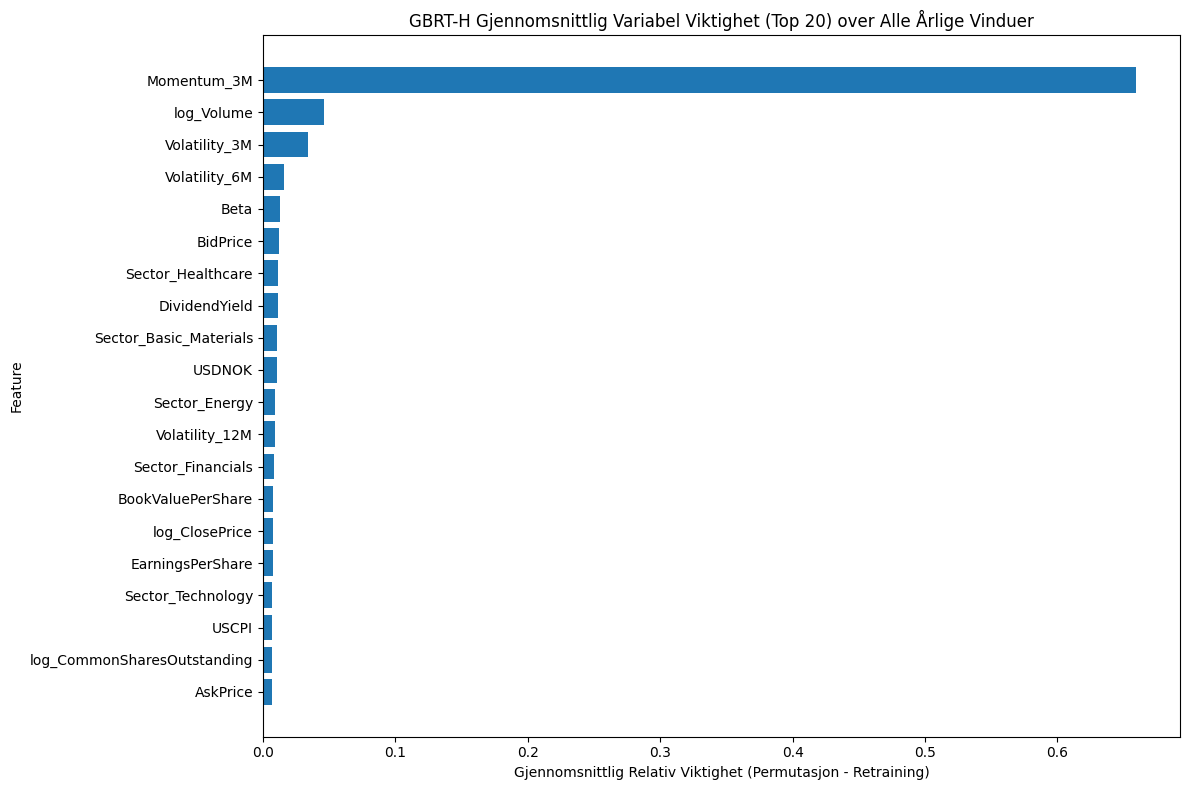


--- Plotter Tidsvarierende Modellkompleksitet (Optimal Max Depth for GBRT-H) ---

--- Optimal optim_max_depth per Vindu Tabell (GBRT-H) ---
        optim_max_depth
Window                 
1                     7
2                     5
3                     3
4                     7
5                     5
6                     7
7                     7
8                     5
9                     7
10                    5
11                    7
12                    7
13                    7
14                    5
15                    7


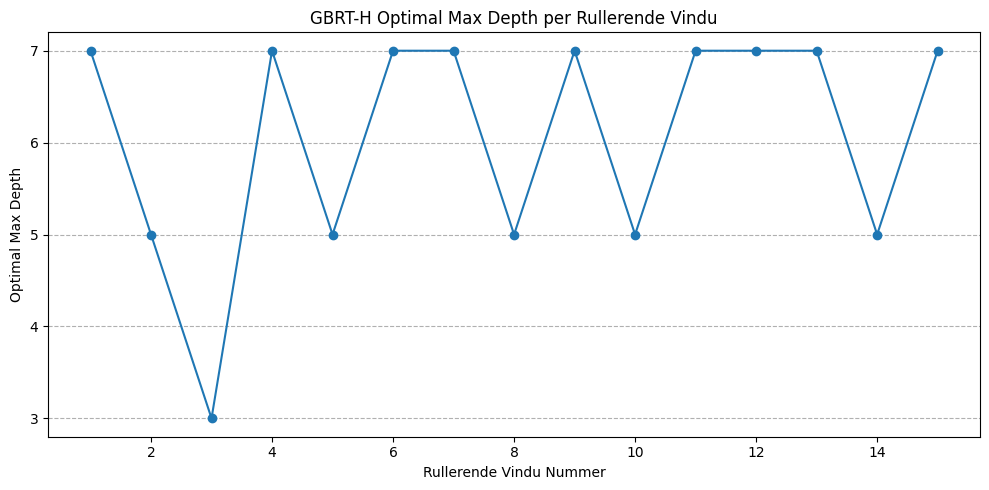


--- Kjøring (All, GBRT-H, Årlig Refit) fullført ---
Sluttid: 2025-04-02 02:30:59 (Total tid: 1:01:38.236578)

==================== Starter Kjøring: GBRT-H for 'Big' Firms (ÅRLIG Refitting) ====================
(Definert som Topp 1000 basert på MarketCap per måned)
Starttid: 2025-04-02 02:30:59

--- Steg 1: Laster og Forbereder Rådata ---
Laster data fra: Cleaned_OSEFX_Market_Macro_Data.csv
Data lastet inn. Form: (34476, 34)
Dato konvertert og data sortert.
Månedlig avkastning ('MonthlyReturn') beregnet/winsorisert.
Risikojustert avkastning ('TargetReturn_t') beregnet (modellens y).
Neste måneds rå avkastning ('NextMonthlyReturn_t+1') beregnet.
Markedsverdi ('MarketCap') beregnet.
Sektor dummy-variabler opprettet.
Kolonnenavn renset.
Log-transformerer spesifikke variabler...
Log-transformasjon fullført.

--- Steg 1.1: Lager Subset: Big ---


<ipython-input-5-887b6f0fa6c4>:1096: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_raw_mc.groupby('MonthYear', group_keys=False).apply(lambda x: x.nlargest(top_n, "MarketCap_orig"))


Subset 'Big' initiell form: (34476, 52)

--- Steg 2 & 1.5: Definerer Features og Rank Standardiserer ---
Identifiserer numeriske features...
  Funnet 50 numeriske kolonner totalt.
  Identifisert 39 features for bruk i modellen.
Rank standardiserer 39 features...
Rank standardisering fullført.

--- Steg 3: Renser Data (Missing/Inf/Filters) ---
Starter datarensing (missing/inf)...
  NaNs imputert med median i 0 feature kolonner.
  Fjernet 188 rader pga. NaN i essensielle kolonner: ['Date', 'Instrument', 'MarketCap_orig', 'NextMonthlyReturn_t+1', 'TargetReturn_t']
  Fjernet 8 rader der MarketCap_orig <= 0.
Datarensing fullført. Form: (34280, 52). Fjernet totalt 196 rader.
  Antall features etter rensing: 39

--- Steg 4: Setter opp ÅRLIG Rullerende Vindu (InitTrain=9, Val=6, Test=1) ---
Unike år i data: 30 (1995 - 2024)
Genererer 15 årlige rullerende vinduer... (Første testår: 2010, Siste startår for test: 2024)

  Vindu 1/15: Train 1995-2003 (4658 obs, 1995-01 to 2003-12), Val 2004-2009 (

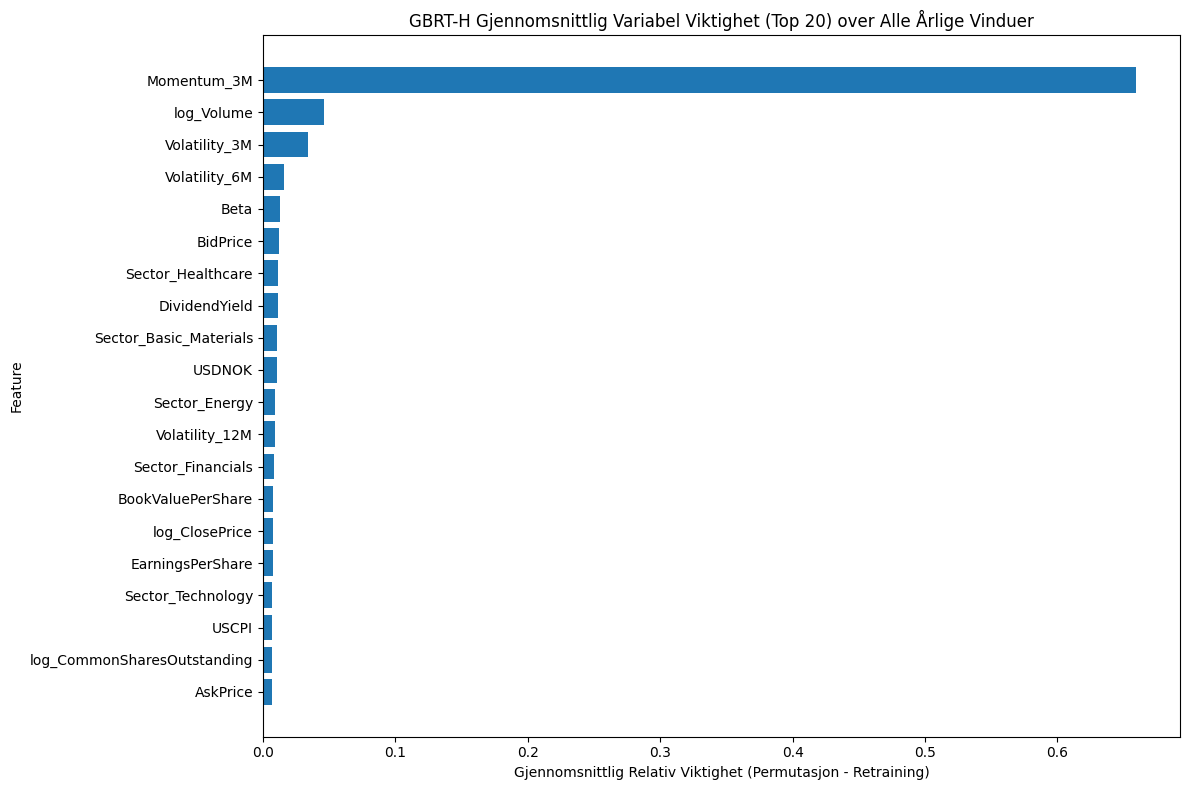


--- Plotter Tidsvarierende Modellkompleksitet (Optimal Max Depth for GBRT-H) ---

--- Optimal optim_max_depth per Vindu Tabell (GBRT-H) ---
        optim_max_depth
Window                 
1                     7
2                     5
3                     3
4                     7
5                     5
6                     7
7                     7
8                     5
9                     7
10                    5
11                    7
12                    7
13                    7
14                    5
15                    7


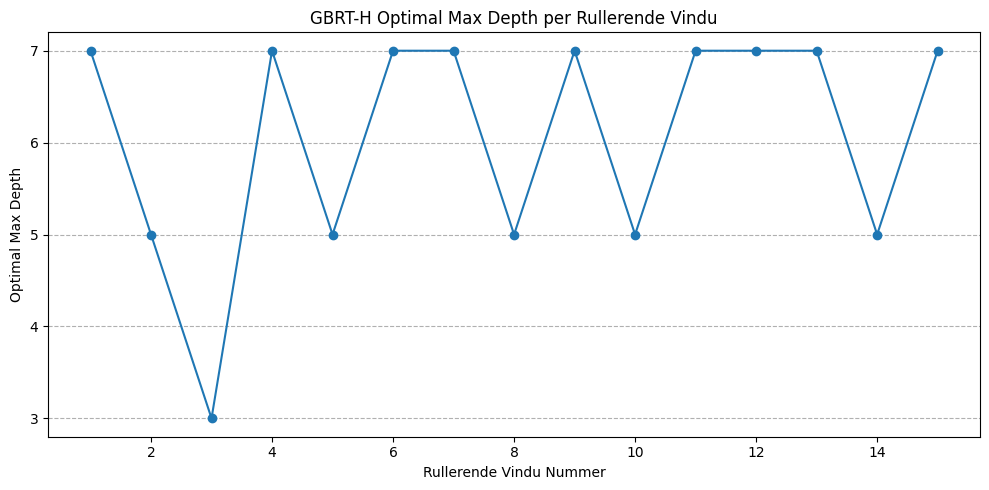


--- Kjøring (Big, GBRT-H, Årlig Refit) fullført ---
Sluttid: 2025-04-02 03:32:23 (Total tid: 1:01:23.262610)

==================== Starter Kjøring: GBRT-H for 'Small' Firms (ÅRLIG Refitting) ====================
(Definert som Bunn 1000 basert på MarketCap per måned)
Starttid: 2025-04-02 03:32:23

--- Steg 1: Laster og Forbereder Rådata ---
Laster data fra: Cleaned_OSEFX_Market_Macro_Data.csv
Data lastet inn. Form: (34476, 34)
Dato konvertert og data sortert.
Månedlig avkastning ('MonthlyReturn') beregnet/winsorisert.
Risikojustert avkastning ('TargetReturn_t') beregnet (modellens y).
Neste måneds rå avkastning ('NextMonthlyReturn_t+1') beregnet.
Markedsverdi ('MarketCap') beregnet.
Sektor dummy-variabler opprettet.
Kolonnenavn renset.
Log-transformerer spesifikke variabler...
Log-transformasjon fullført.

--- Steg 1.1: Lager Subset: Small ---


<ipython-input-5-887b6f0fa6c4>:1100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_raw_mc.groupby('MonthYear', group_keys=False).apply(lambda x: x.nsmallest(bottom_n, "MarketCap_orig"))


Subset 'Small' initiell form: (34476, 52)

--- Steg 2 & 1.5: Definerer Features og Rank Standardiserer ---
Identifiserer numeriske features...
  Funnet 50 numeriske kolonner totalt.
  Identifisert 39 features for bruk i modellen.
Rank standardiserer 39 features...
Rank standardisering fullført.

--- Steg 3: Renser Data (Missing/Inf/Filters) ---
Starter datarensing (missing/inf)...
  NaNs imputert med median i 0 feature kolonner.
  Fjernet 188 rader pga. NaN i essensielle kolonner: ['Date', 'Instrument', 'MarketCap_orig', 'NextMonthlyReturn_t+1', 'TargetReturn_t']
  Fjernet 8 rader der MarketCap_orig <= 0.
Datarensing fullført. Form: (34280, 52). Fjernet totalt 196 rader.
  Antall features etter rensing: 39

--- Steg 4: Setter opp ÅRLIG Rullerende Vindu (InitTrain=9, Val=6, Test=1) ---
Unike år i data: 30 (1995 - 2024)
Genererer 15 årlige rullerende vinduer... (Første testår: 2010, Siste startår for test: 2024)

  Vindu 1/15: Train 1995-2003 (4658 obs, 1995-01 to 2003-12), Val 2004-2009

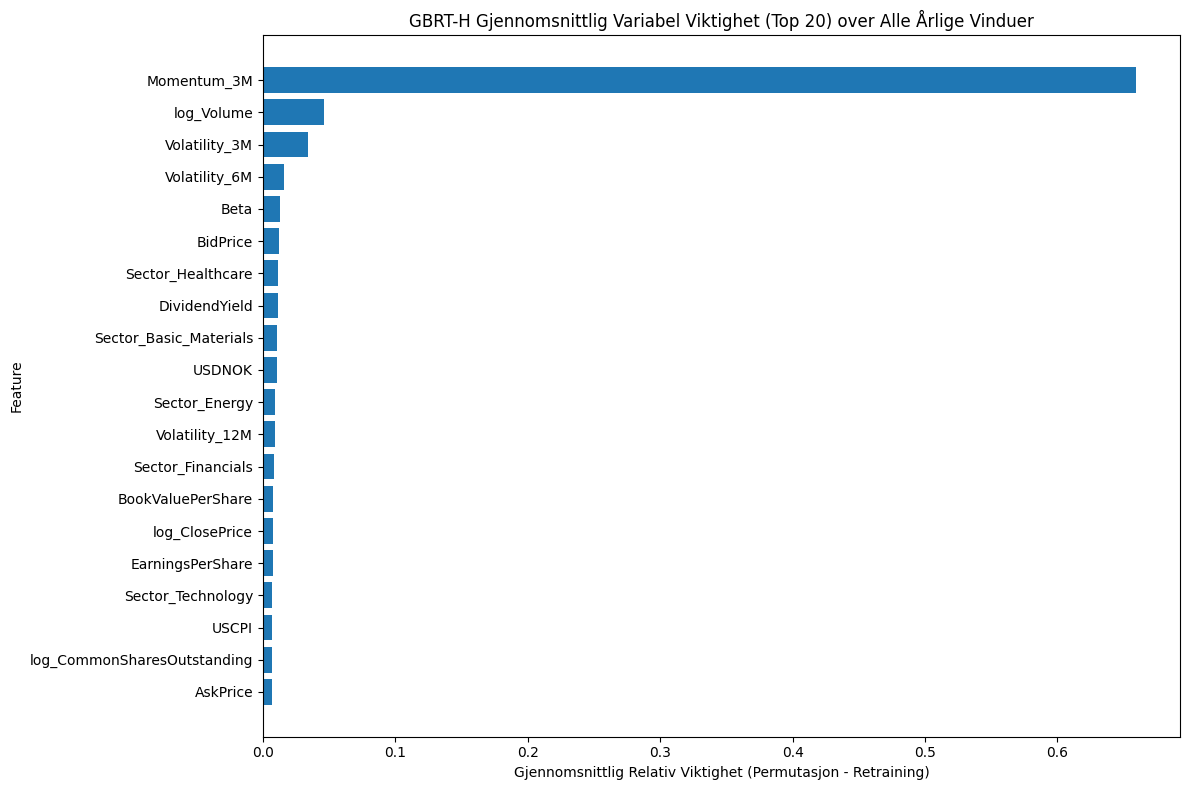


--- Plotter Tidsvarierende Modellkompleksitet (Optimal Max Depth for GBRT-H) ---

--- Optimal optim_max_depth per Vindu Tabell (GBRT-H) ---
        optim_max_depth
Window                 
1                     7
2                     5
3                     3
4                     7
5                     5
6                     7
7                     7
8                     5
9                     7
10                    5
11                    7
12                    7
13                    7
14                    5
15                    7


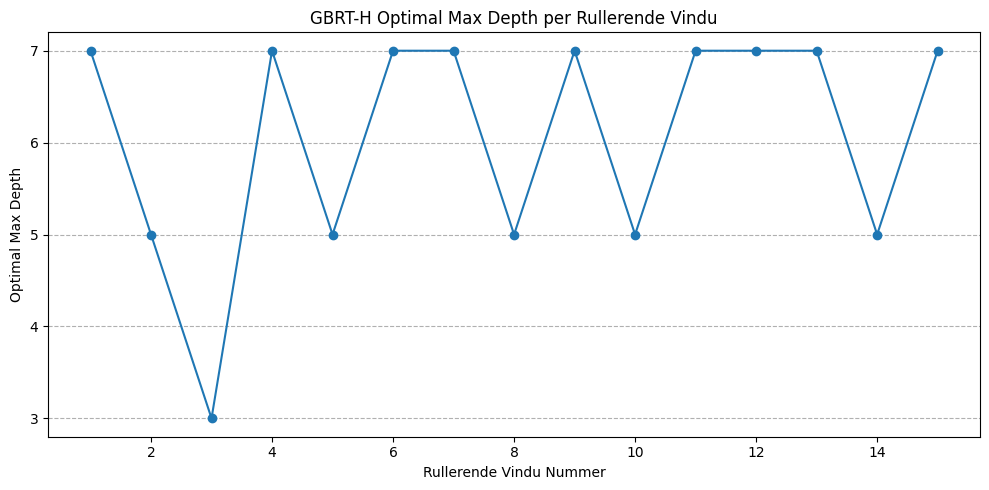


--- Kjøring (Small, GBRT-H, Årlig Refit) fullført ---
Sluttid: 2025-04-02 04:33:39 (Total tid: 1:01:16.856167)


============================== Final OOS R2 Summary (GBRT-H - Yearly Refit) ==============================
                           GBRT-H R2oos (%)
Full Sample (all)                   18.4796
Large Firms (Top 1000)              18.4796
Small Firms (Bottom 1000)           18.4796
 -> R2 Sammendrag lagret til GBRT_H_Results_YearlyRefit/gbrt-h_R2oos_summary_subsets_yearly.csv

Lagrer Gjennomsnittlig Variabel Viktighet resultater (fra 'all' subset)...
 -> Gjennomsnittlig Variabel Viktighet lagret til GBRT_H_Results_YearlyRefit/gbrt-h_variable_importance_averaged_yearly.csv

Lagrer Portefølje Desil- og Risikotabeller for hver subset...
 -> Porteføljetabell (all, decile_ew) lagret til GBRT_H_Results_YearlyRefit/gbrt-h_portfolio_all_decile_ew_yearly.csv
 -> Porteføljetabell (all, decile_vw) lagret til GBRT_H_Results_YearlyRefit/gbrt-h_portfolio_all_decile_vw_yearly.csv
 -> Port

In [5]:
# -*- coding: utf-8 -*-
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.metrics import r2_score, mean_squared_error
# *** Import GBRT ***
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
# *** Import for Factor Regressions ***
import statsmodels.api as sm # <--- Un-commented for portfolio analysis
import datetime
import warnings
import traceback
from collections import defaultdict
import os
import time # For timing VI

# --- WARNINGS CONFIGURATION ---
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in log")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Maximum number of iterations reached.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide") # Added for Sharpe ratio etc.
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Degrees of freedom <= 0 for slice") # Added for std dev etc.
pd.options.mode.chained_assignment = None

# --------------------------------------------------------------------------
# FUNCTION DEFINITIONS
# --------------------------------------------------------------------------

# Step 1: Load and Prepare Dataset
def load_prepare_data(file_path):
    """ Loads, cleans, calculates returns/market cap, handles dates/IDs. """
    print(f"Laster data fra: {file_path}")
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except FileNotFoundError: print(f"FEIL: Fil '{file_path}' ikke funnet."); return None
    print(f"Data lastet inn. Form: {df.shape}")

    # Standardize essential column names (adjust if your CSV uses different names)
    date_col = 'Date' if 'Date' in df.columns else 'eom'
    id_col = 'Instrument' if 'Instrument' in df.columns else 'id'
    price_col = 'ClosePrice' if 'ClosePrice' in df.columns else 'prc'
    shares_col = 'CommonSharesOutstanding'
    rf_col = 'NorgesBank10Y'
    sector_col = 'EconomicSector'

    if date_col not in df.columns: print("FEIL: Dato-kolonne mangler."); return None
    if id_col not in df.columns: print("FEIL: Instrument-ID mangler."); return None
    if price_col not in df.columns: print(f"FEIL: Pris-kolonne ('{price_col}') mangler."); return None

    df = df.rename(columns={date_col: 'Date', id_col: 'Instrument'})
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)
    print("Dato konvertert og data sortert.")

    # Return Calculation
    df["MonthlyReturn"] = df.groupby("Instrument")[price_col].pct_change()
    df["MonthlyReturn"].fillna(0, inplace=True)
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    print("Månedlig avkastning ('MonthlyReturn') beregnet/winsorisert.")

    # Target Variable (Adjusted Return)
    if rf_col not in df.columns: df[rf_col] = 0; print(f"ADVARSEL: '{rf_col}' mangler, bruker 0.")
    # Handle potential percentage vs decimal format for risk-free rate
    df["MonthlyRiskFreeRate_t"] = df[rf_col] / 12 / 100 if df[rf_col].abs().max() > 1 else df[rf_col] / 12
    df["TargetReturn_t"] = df["MonthlyReturn"] - df["MonthlyRiskFreeRate_t"] # Model target y
    print("Risikojustert avkastning ('TargetReturn_t') beregnet (modellens y).")

    # Next Month's RAW Return (for portfolio eval)
    df['NextMonthlyReturn_t+1'] = df.groupby('Instrument')['MonthlyReturn'].shift(-1)
    print("Neste måneds rå avkastning ('NextMonthlyReturn_t+1') beregnet.")

    # Market Cap
    if shares_col not in df.columns: print(f"FEIL: '{shares_col}' mangler for MarketCap."); return None
    df["MarketCap"] = df[price_col] * df[shares_col]
    df['MarketCap_orig'] = df['MarketCap'].copy() # Keep original market cap for portfolio weighting
    df['MarketCap'] = df['MarketCap'].fillna(0)
    print("Markedsverdi ('MarketCap') beregnet.")

    # Sector Dummies (Optional)
    if sector_col in df.columns:
        df = pd.get_dummies(df, columns=[sector_col], prefix="Sector", dtype=int)
        print("Sektor dummy-variabler opprettet.")

    # Clean Column Names
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")
    print("Kolonnenavn renset.")

    # Log Transformation
    print("Log-transformerer spesifikke variabler...")
    vars_to_log = ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]
    vars_to_log = [v if v in df.columns else v.lower() for v in vars_to_log]
    vars_to_log = [v if v in df.columns else 'prc' if v == 'closeprice' else v for v in vars_to_log]
    vars_to_log = [col for col in vars_to_log if col in df.columns]
    for var in vars_to_log:
        if var in df.columns and pd.api.types.is_numeric_dtype(df[var]):
             # Added check for non-positive values before log
             df[f"{var}_positive"] = df[var].where(df[var] > 1e-9, np.nan) # Use small threshold > 0
             df[f"log_{var}"] = np.log(df[f"{var}_positive"])
             log_median = df[f"log_{var}"].median() # Calculate median of the log-transformed values
             df[f"log_{var}"] = df[f"log_{var}"].fillna(log_median) # Impute NaNs in log-transformed col with log median
             if pd.isna(log_median): df[f"log_{var}"] = df[f"log_{var}"].fillna(0) # If median is NaN (rare), fill with 0
             df.drop(columns=[f"{var}_positive"], inplace=True) # Drop temporary positive column
        # else: print(f"  ADVARSEL: Kolonne '{var}' ikke funnet eller ikke numerisk, hopper over log.") # Keep less verbose
    print("Log-transformasjon fullført.")

    # Ensure MarketCap_orig exists after log transform potentially overwriting MarketCap
    if 'MarketCap_orig' not in df.columns and 'MarketCap' in df.columns:
         df['MarketCap_orig'] = df['MarketCap'].copy() # Recopy if overwritten

    return df


# Step 1.5: Rank Standardization
def rank_standardize_features(df, features_to_standardize):
    print(f"Rank standardiserer {len(features_to_standardize)} features...")
    if 'Date' not in df.columns: print("FEIL: 'Date' mangler."); return df
    features_present = [f for f in features_to_standardize if f in df.columns]
    if len(features_present) < len(features_to_standardize):
        missing = [f for f in features_to_standardize if f not in features_present]; print(f"  ADVARSEL: Features manglet for standardisering: {missing}")
    if not features_present: print("  Ingen features å standardisere."); return df
    # Define the transformation function (handles potential non-numeric gracefully)
    def rank_transform(x):
        x_numeric = pd.to_numeric(x, errors='coerce') # Convert to numeric, coercing errors to NaT/NaN
        ranks = x_numeric.rank(pct=True, na_option='keep') # Rank, keeping NaNs
        return ranks * 2 - 1 # Scale to [-1, 1]
    try:
        # Apply the transformation using transform (faster)
        ranked_cols = df.groupby('Date')[features_present].transform(rank_transform)
        df[features_present] = ranked_cols
    except Exception as e:
        print(f"  ADVARSEL under rank standardisering (transform): {e}. Prøver apply (langsommere).")
        # Fallback using apply (slower but sometimes more robust)
        try:
            df_std = df.set_index('Date')
            for col in features_present:
                df_std[col] = df_std.groupby(level=0)[col].apply(rank_transform)
            df = df_std.reset_index()
        except Exception as e2:
            print(f"  FEIL: Også alternativ standardisering feilet: {e2}"); return df # Return original df if fallback fails
    print("Rank standardisering fullført.")
    return df


# Step 2: Define Feature Sets
def define_features(df):
    print("Identifiserer numeriske features...")
    if df is None or df.empty: print("  FEIL: DataFrame er tom."); return []
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    print(f"  Funnet {len(numeric_cols)} numeriske kolonner totalt.")
    # Define columns to exclude from features
    cols_to_exclude = [
        'Instrument', 'Date', 'level_0', 'index', 'Year', 'MonthYear', # Identifiers, helpers
        'TargetReturn_t', 'NextMonthlyReturn_t+1', 'MonthlyReturn', 'MonthlyRiskFreeRate_t', # Target & related returns
        'MarketCap_orig', # Original market cap (used for weighting, not feature)
        'rank', 'DecileRank', 'ew_weights', 'vw_weights', # Portfolio construction helpers
    ]
    # Add any other dynamically generated return columns
    cols_to_exclude.extend([col for col in df.columns if 'return_stock' in col or 'return_portfolio' in col])
    # Handle log-transformed features: exclude the original if log version exists
    log_cols = [col for col in numeric_cols if col.startswith('log_')]
    originals_of_log = [col.replace('log_','') for col in log_cols]
    # Specify common originals we definitely want to exclude if log exists
    common_originals = ['MarketCap', 'ClosePrice', 'prc', 'Volume', 'CommonSharesOutstanding', 'BM']
    originals_to_exclude = [orig for orig in originals_of_log if orig in df.columns and orig in common_originals]
    cols_to_exclude.extend(originals_to_exclude)
    cols_to_exclude = list(set(cols_to_exclude)) # Remove duplicates

    # Identify potential features
    potential_features = [col for col in numeric_cols if col not in cols_to_exclude]
    # Final check: Ensure feature is in DataFrame, has more than 1 unique value (excluding NaN), and has non-zero std dev
    final_features = []
    for col in potential_features:
        if col in df.columns:
            series = df[col].dropna() # Drop NaNs for nunique and std checks
            if series.nunique() > 1 and series.std(ddof=0) > 1e-9: # Check variability
                 final_features.append(col)
            # else: print(f"  Feature '{col}' ekskludert (kun én verdi eller null std dev).") # Optional debug info

    final_features = sorted(list(set(final_features))) # Ensure unique and sorted
    print(f"  Identifisert {len(final_features)} features for bruk i modellen.")
    # print(f"  Features: {final_features}") # Optional: print feature list
    return final_features


# Step 3: Handle Missing / Infinite Values
def clean_data(df, numeric_features_to_impute, essential_cols_for_dropna, target="TargetReturn_t"):
    print("Starter datarensing (missing/inf)..."); initial_rows = len(df)
    # Impute NaNs/Infs in FEATURES
    features_present = [f for f in numeric_features_to_impute if f in df.columns]
    if features_present:
        # Replace Inf/-Inf with NaN first
        inf_mask = df[features_present].isin([np.inf, -np.inf])
        if inf_mask.any().any():
            print(f"  Erstatter inf med NaN i {inf_mask.any(axis=0).sum()} feature kolonner...")
            df[features_present] = df[features_present].replace([np.inf, -np.inf], np.nan)
        # Impute NaNs using median
        nan_counts_before = df[features_present].isnull().sum()
        medians = df[features_present].median(skipna=True) # Calculate medians (robust to outliers)
        df[features_present] = df[features_present].fillna(medians) # Fill NaNs with respective column median
        nan_counts_after = df[features_present].isnull().sum()
        imputed_cols = (nan_counts_before - nan_counts_after)
        print(f"  NaNs imputert med median i {imputed_cols[imputed_cols > 0].count()} feature kolonner.")
        # Handle cases where median itself is NaN (e.g., column is all NaN) - fill with 0
        if medians.isnull().any():
            cols_nan_median = medians[medians.isnull()].index.tolist()
            print(f"  ADVARSEL: Median var NaN for features: {cols_nan_median}. Fyller disse med 0.")
            df[cols_nan_median] = df[cols_nan_median].fillna(0)

    # Drop rows with NaNs in ESSENTIAL columns (target, IDs, portfolio construction vars)
    essential_cols_present = [col for col in essential_cols_for_dropna if col in df.columns]
    # Automatically add target, next return, and market cap if they exist and aren't already included
    for col in [target,'NextMonthlyReturn_t+1','MarketCap_orig']:
        if col in df.columns and col not in essential_cols_present:
             essential_cols_present.append(col)
    unique_essential_cols = sorted(list(set(essential_cols_present))) # Ensure unique and sorted

    if unique_essential_cols:
        rows_before_dropna = len(df)
        df = df.dropna(subset=unique_essential_cols)
        rows_dropped = rows_before_dropna - len(df)
        if rows_dropped > 0:
            print(f"  Fjernet {rows_dropped} rader pga. NaN i essensielle kolonner: {unique_essential_cols}")
    # else: print("  Ingen essensielle kolonner spesifisert for dropna.") # Less verbose

    # Filter based on Original Market Cap (important for portfolio construction)
    mc_orig_col = 'MarketCap_orig'
    if mc_orig_col in df.columns:
        rows_before_mc_filter = len(df)
        df = df[df[mc_orig_col] > 0] # Keep only firms with positive market cap
        rows_dropped_mc = rows_before_mc_filter - len(df)
        if rows_dropped_mc > 0:
            print(f"  Fjernet {rows_dropped_mc} rader der {mc_orig_col} <= 0.")
    # else: print(f"  Advarsel: '{mc_orig_col}' ikke funnet for filtrering.") # Less verbose

    final_rows = len(df)
    print(f"Datarensing fullført. Form: {df.shape}. Fjernet totalt {initial_rows - final_rows} rader.")
    if df.empty:
        print("FEIL: Ingen data igjen etter rensing.")
    return df


# Step 4: Yearly Rolling Window Splits
def get_yearly_rolling_splits(df, initial_train_years, val_years, test_years=1):
    if "Date" not in df.columns: raise ValueError("'Date'-kolonnen mangler.")
    df['Year'] = df["Date"].dt.year
    unique_years = sorted(df["Year"].unique())
    n_unique_years = len(unique_years)
    print(f"Unike år i data: {n_unique_years} ({unique_years[0]} - {unique_years[-1]})")

    # Check if there are enough years for at least one split
    if n_unique_years < initial_train_years + val_years + test_years:
        df.drop(columns=['Year'], inplace=True, errors='ignore')
        raise ValueError(f"Ikke nok unike år ({n_unique_years}) for den spesifiserte split "
                         f"(trenger minst {initial_train_years + val_years + test_years} år).")

    # Determine the first year for the test set
    first_test_year_index = initial_train_years + val_years
    if first_test_year_index >= n_unique_years:
        df.drop(columns=['Year'], inplace=True, errors='ignore')
        raise ValueError("Kombinasjonen av initial_train_years og val_years er for lang, "
                         "etterlater ingen år for testing.")

    first_test_year = unique_years[first_test_year_index]
    last_possible_test_start_year = unique_years[-test_years] # The last year a test window *can* start

    # Calculate the number of rolling windows
    num_windows = last_possible_test_start_year - first_test_year + 1
    if num_windows <= 0:
        df.drop(columns=['Year'], inplace=True, errors='ignore')
        raise ValueError("Start/slutt år for testvinduer resulterer i 0 eller negativt antall vinduer.")

    print(f"Genererer {num_windows} årlige rullerende vinduer... "
          f"(Første testår: {first_test_year}, Siste startår for test: {last_possible_test_start_year})")

    splits_info = [] # To store info before yielding

    for i in range(num_windows):
        # Define years for the current window
        current_test_start_year = first_test_year + i
        current_test_end_year = current_test_start_year + test_years - 1

        current_val_end_year = current_test_start_year - 1
        current_val_start_year = current_val_end_year - val_years + 1

        current_train_end_year = current_val_start_year - 1
        # Training always starts from the first available year in the dataset
        current_train_start_year = unique_years[0] # Expanding window for training

        # Get indices for train, validation, and test sets
        train_idx = df[(df['Year'] >= current_train_start_year) & (df['Year'] <= current_train_end_year)].index
        val_idx = df[(df['Year'] >= current_val_start_year) & (df['Year'] <= current_val_end_year)].index
        test_idx = df[(df['Year'] >= current_test_start_year) & (df['Year'] <= current_test_end_year)].index

        # Get date ranges for reporting
        train_dates = df.loc[train_idx, "Date"].agg(['min', 'max']) if not train_idx.empty else pd.Series([pd.NaT, pd.NaT], index=['min', 'max'])
        val_dates = df.loc[val_idx, "Date"].agg(['min', 'max']) if not val_idx.empty else pd.Series([pd.NaT, pd.NaT], index=['min', 'max'])
        test_dates = df.loc[test_idx, "Date"].agg(['min', 'max']) if not test_idx.empty else pd.Series([pd.NaT, pd.NaT], index=['min', 'max'])

        splits_info.append((train_idx, val_idx, test_idx, train_dates, val_dates, test_dates,
                            current_train_start_year, current_train_end_year,
                            current_val_start_year, current_val_end_year,
                            current_test_start_year, current_test_end_year))

    # Now yield the results after printing the summary
    for i, split_data in enumerate(splits_info):
        train_idx, val_idx, test_idx, train_dates, val_dates, test_dates, \
        tr_s, tr_e, v_s, v_e, t_s, t_e = split_data

        print(f"\n  Vindu {i+1}/{num_windows}: "
              f"Train {tr_s}-{tr_e} ({len(train_idx)} obs, {train_dates['min'].strftime('%Y-%m') if pd.notna(train_dates['min']) else 'N/A'} to {train_dates['max'].strftime('%Y-%m') if pd.notna(train_dates['max']) else 'N/A'}), "
              f"Val {v_s}-{v_e} ({len(val_idx)} obs, {val_dates['min'].strftime('%Y-%m') if pd.notna(val_dates['min']) else 'N/A'} to {val_dates['max'].strftime('%Y-%m') if pd.notna(val_dates['max']) else 'N/A'}), "
              f"Test {t_s}-{t_e} ({len(test_idx)} obs, {test_dates['min'].strftime('%Y-%m') if pd.notna(test_dates['min']) else 'N/A'} to {test_dates['max'].strftime('%Y-%m') if pd.notna(test_dates['max']) else 'N/A'})")

        yield train_idx, val_idx, test_idx, train_dates, val_dates, test_dates

    # Clean up the temporary 'Year' column
    df.drop(columns=['Year'], inplace=True, errors='ignore')


# --------------------------------------------------------------------------
# Step 5: Run GBRT with Huber Loss on a Single Rolling Window
# --------------------------------------------------------------------------
def run_gbrt_h_on_window(X_train, y_train, X_val, y_val, X_test, y_test, param_grid=None):
    """ Trains GBRT with Huber loss, tunes hyperparameters on validation set.
        Returns the trained model, OOS predictions, IS+Val predictions, metrics & optimal parameters. """
    model = None
    optim_param_found = None
    optimal_max_depth = np.nan
    preds_oos = np.full(y_test.shape[0], np.nan)
    # Predictions on the combined training and validation set used for final model fitting
    preds_is_train_val = np.full(y_train.shape[0] + y_val.shape[0], np.nan)
    r2_oos, mse_oos, sharpe_oos, r2_is_train_val = (np.nan,) * 4

    # Default GBRT-H Hyperparameter Grid (Inspired by example, adapt as needed)
    if param_grid is None:
         param_grid = {
             'n_estimators': [100],        # Fixed number of trees (like example, often tuned)
             'learning_rate': [0.1, 0.05], # Common values
             'max_depth': [3, 5, 7],       # Tree depth
             'min_samples_split': [1000, 2000], # Min samples to split internal node
             'min_samples_leaf': [500, 1000], # Min samples in leaf node
             'max_features': ['sqrt'],     # Consider sqrt(n_features) at each split
             'alpha': [0.9, 0.95]          # Quantile for Huber loss (sklearn default 0.9)
             # 'subsample': [0.7]          # Optional: Fraction of samples for fitting trees (stochastic GB)
         }

    grid = list(ParameterGrid(param_grid))
    best_mse_val = np.inf

    # Basic checks for valid data
    if X_val.shape[0] < 2 or y_val.shape[0] < 2 or np.isnan(y_val).all():
        print("    ADVARSEL: Valideringssettet for lite eller inneholder bare NaNs. Hopper over tuning/trening.")
        return model, preds_oos, r2_oos, mse_oos, sharpe_oos, preds_is_train_val, r2_is_train_val, optimal_max_depth, optim_param_found

    if X_train.shape[0] < 2 or y_train.shape[0] < 2 or np.isnan(y_train).all():
        print("    ADVARSEL: Treningssettet for lite eller inneholder bare NaNs. Hopper over tuning/trening.")
        return model, preds_oos, r2_oos, mse_oos, sharpe_oos, preds_is_train_val, r2_is_train_val, optimal_max_depth, optim_param_found

    # --- Hyperparameter Tuning Loop ---
    # print(f"    Tuner GBRT-H ({len(grid)} kombinasjoner)...") # Verbose
    for i, params in enumerate(grid):
        try:
             gbrt_val = GradientBoostingRegressor(loss='huber', random_state=42, **params) # Added random_state
             gbrt_val.fit(X_train, y_train)
             y_val_pred = gbrt_val.predict(X_val)

             # Check for non-finite predictions or targets in validation set
             valid_val_mask = np.isfinite(y_val) & np.isfinite(y_val_pred)
             if not valid_val_mask.any(): continue # Skip if no valid comparison points

             y_val_valid = y_val[valid_val_mask]
             y_val_pred_valid = y_val_pred[valid_val_mask]

             if y_val_valid.shape[0] < 1: continue # Should not happen if any() is true, but safe check

             current_mse_val = mean_squared_error(y_val_valid, y_val_pred_valid)

             # Update best parameters if current MSE is better and finite
             if not np.isnan(current_mse_val) and current_mse_val < best_mse_val:
                 best_mse_val = current_mse_val
                 optim_param_found = params

        except Exception as e:
             # print(f"      Tuning error for params {params}: {e}") # Optional debug
             continue # Continue to next parameter combination

    if optim_param_found is None:
        print("    FEIL: GBRT-H Tuning feilet (ingen gyldig parameterkombinasjon funnet). Hopper over trening.")
        return model, preds_oos, r2_oos, mse_oos, sharpe_oos, preds_is_train_val, r2_is_train_val, optimal_max_depth, optim_param_found

    optimal_max_depth = optim_param_found.get('max_depth', np.nan)
    # print(f"    Optimal GBRT-H params funnet (basert på Val MSE): {optim_param_found}") # Verbose

    # --- Final Training on Train + Validation ---
    preds_is_full = np.full(y_train.shape[0] + y_val.shape[0], np.nan) # Initialize with NaNs
    try:
        # print("    Trener endelig GBRT-H på Train+Val med optimale parametre...") # Verbose
        # Combine training and validation data
        X_train_val = np.vstack((X_train, X_val))
        y_train_val = np.concatenate((y_train, y_val))

        # Filter out any potential NaNs in the combined target array before final training
        valid_train_val_mask = np.isfinite(y_train_val)
        if not valid_train_val_mask.any():
             raise ValueError("Ingen gyldige target verdier i kombinert train+val sett.")
        X_train_val_final = X_train_val[valid_train_val_mask]
        y_train_val_final = y_train_val[valid_train_val_mask]
        if X_train_val_final.shape[0] < 2 :
             raise ValueError("Ikke nok gyldige observasjoner i train+val for endelig trening.")

        model = GradientBoostingRegressor(loss='huber', random_state=42, **optim_param_found)
        model.fit(X_train_val_final, y_train_val_final)

        # --- OOS Evaluation (on Test set) ---
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            preds_oos = model.predict(X_test)
            nan_preds_oos_mask = ~np.isfinite(preds_oos)
            if nan_preds_oos_mask.any():
                 # print(f"    ADVARSEL: Fant {nan_preds_oos_mask.sum()} ikke-endelige OOS prediksjoner. Setter til 0.") # Less verbose
                 preds_oos[nan_preds_oos_mask] = 0 # Impute non-finite predictions

            # Calculate OOS R2 using valid targets and predictions
            valid_oos_mask = np.isfinite(y_test) & np.isfinite(preds_oos)
            y_test_valid = y_test[valid_oos_mask]
            preds_oos_valid = preds_oos[valid_oos_mask]

            if len(preds_oos_valid) > 1 and y_test_valid.std() > 1e-9 : # Need variance in target
                 # Gu et al. (2020) R2 definition: 1 - SS_res / SS_true_sq
                 ss_res_oos = np.sum((y_test_valid - preds_oos_valid)**2)
                 ss_tot_oos_zero_mean = np.sum(y_test_valid**2) # Sum of squares of true values (centered at 0)
                 if ss_tot_oos_zero_mean > 1e-15: # Avoid division by zero
                     r2_oos = 1 - (ss_res_oos / ss_tot_oos_zero_mean)
                 else: r2_oos = np.nan # Undefined if true values have no variance around 0

                 mse_oos = mean_squared_error(y_test_valid, preds_oos_valid)

                 # OOS Sharpe Ratio of predictions (hypothetical strategy performance)
                 pred_std_oos = np.std(preds_oos_valid)
                 sharpe_oos = (np.mean(preds_oos_valid) / pred_std_oos) * np.sqrt(12) if pred_std_oos > 1e-9 else np.nan

        # --- IS Evaluation (on the data used for final training: Train+Val) ---
        preds_is_train_val = model.predict(X_train_val_final) # Predict on the filtered train+val data
        nan_preds_is_mask = ~np.isfinite(preds_is_train_val)
        if nan_preds_is_mask.any():
            # print(f"    ADVARSEL: Fant {nan_preds_is_mask.sum()} ikke-endelige IS (Train+Val) prediksjoner. Setter til 0.") # Less verbose
            preds_is_train_val[nan_preds_is_mask] = 0 # Impute non-finite predictions

        # Calculate IS R2 using valid targets and predictions from the final training set
        # Note: y_train_val_final already filtered for NaNs
        valid_is_mask = np.isfinite(preds_is_train_val) # Only need to check predictions now
        y_train_val_valid = y_train_val_final[valid_is_mask]
        preds_is_valid = preds_is_train_val[valid_is_mask]

        if len(preds_is_valid) > 1 and y_train_val_valid.std() > 1e-9: # Need variance in target
             # Gu et al. R2 definition for IS
             ss_res_is = np.sum((y_train_val_valid - preds_is_valid)**2)
             ss_tot_is_zero_mean = np.sum(y_train_val_valid**2) # Sum of squares of true values (centered at 0)
             if ss_tot_is_zero_mean > 1e-15:
                 r2_is_train_val = 1 - (ss_res_is / ss_tot_is_zero_mean)
             else: r2_is_train_val = np.nan

        # Adjust preds_is_train_val to match the original length of y_train_val, filling NaNs where original was NaN
        # Place the valid predictions back into the full-sized array based on the valid mask used for training
        preds_is_full[valid_train_val_mask] = preds_is_train_val


    except Exception as e:
        print(f"  FEIL under endelig GBRT-H trening/prediksjon: {e}")
        # traceback.print_exc() # Optional detailed traceback
        model = None; optimal_max_depth = np.nan; optim_param_found = None # Reset optimal params too
        preds_oos.fill(np.nan); preds_is_full.fill(np.nan)
        r2_oos, mse_oos, sharpe_oos, r2_is_train_val = (np.nan,) * 4

    # Return optimal_max_depth and optimal parameters found during tuning
    return model, preds_oos, r2_oos, mse_oos, sharpe_oos, preds_is_full, r2_is_train_val, optimal_max_depth, optim_param_found


# -----------------------------------------------------------------------------
# Step 6.7: Variable Importance Function (MODIFIED for GBRT)
# -----------------------------------------------------------------------------
def calculate_variable_importance_single_window(model_params, X_eval, y_eval, features, base_r2):
    """
    Calculates permutation importance for GBRT-H for ONE window using Retraining.
    Retrains the model with the same hyperparameters for each zeroed-out feature.
    WARNING: Computationally expensive for GBRT. Uses IS R2 as base.
    """
    importance_results = {}
    n_features = X_eval.shape[1]

    # Ensure y_eval is clean and calculate total sum of squares (using zero mean R2 definition)
    valid_eval_mask = np.isfinite(y_eval)
    if not valid_eval_mask.any():
        print("  ADVARSEL (VI): Ingen gyldige target verdier i evalueringssettet. Kan ikke beregne viktighet.")
        return pd.DataFrame({'Feature': features, 'Importance': 0.0})

    y_eval_clean = y_eval[valid_eval_mask]
    X_eval_clean = X_eval[valid_eval_mask]
    if X_eval_clean.shape[0] < 2 or y_eval_clean.std() < 1e-9:
        print("  ADVARSEL (VI): Ikke nok data eller varians i evalueringssettet. Kan ikke beregne viktighet.")
        return pd.DataFrame({'Feature': features, 'Importance': 0.0})

    ss_tot_eval = np.sum(y_eval_clean**2)
    if ss_tot_eval < 1e-15:
        # print("  ADVARSEL (VI): Total sum of squares for target er nær null. Viktighet blir 0.") # Less verbose
        return pd.DataFrame({'Feature': features, 'Importance': 0.0})

    # We need the optimal parameters found for this window's main model
    if not model_params:
         print("  ADVARSEL (VI): Modellparametre ikke gitt. Kan ikke beregne viktighet.")
         return pd.DataFrame({'Feature': features, 'Importance': 0.0})

    # Ensure loss is set correctly and random_state for reproducibility
    current_model_params = model_params.copy()
    current_model_params['loss'] = 'huber' # Ensure Huber loss is used
    current_model_params['random_state'] = 42 # For reproducibility

    # --- Calculate R2 for each permuted feature ---
    r2_reductions = {}
    for feature_idx, feature_name in enumerate(features):
        X_eval_permuted = X_eval_clean.copy()

        # Zero-out the feature column
        X_eval_permuted[:, feature_idx] = 0

        try:
            # Re-train GBRT with the zeroed feature using same optimal params
            # Note: Training on the potentially large X_eval_clean set each time
            permuted_model = GradientBoostingRegressor(**current_model_params)
            permuted_model.fit(X_eval_permuted, y_eval_clean) # Train on modified data

            # Predict on the same modified data
            permuted_preds = permuted_model.predict(X_eval_permuted)

            # Check for non-finite predictions
            valid_preds_mask = np.isfinite(permuted_preds)
            if not valid_preds_mask.all():
                # print(f"    ADVARSEL (VI): Ikke-endelige prediksjoner for feature '{feature_name}'. Setter R2 red. til 0.") # Less verbose
                permuted_r2 = np.nan # Mark as invalid
            else:
                # Calculate R2 on the clean evaluation set
                ss_res_permuted = np.sum((y_eval_clean - permuted_preds)**2)
                permuted_r2 = 1 - (ss_res_permuted / ss_tot_eval)

            # Importance is the reduction in R2 compared to the base R2
            # Use max(0, ...) because permuting can sometimes *improve* R2 by chance
            if pd.notna(base_r2) and pd.notna(permuted_r2):
                 r2_reduction = base_r2 - permuted_r2
                 r2_reductions[feature_name] = max(0, r2_reduction)
            else:
                 r2_reductions[feature_name] = 0.0 # Assign 0 if base or permuted R2 is NaN


        except Exception as e:
            # print(f"    FEIL under VI re-trening for feature '{feature_name}': {e}") # Keep less verbose
            r2_reductions[feature_name] = 0.0 # Assign 0 importance if retraining fails

    # --- Normalize Importance Scores ---
    if not r2_reductions:
        return pd.DataFrame({'Feature': features, 'Importance': 0.0})

    imp_df = pd.DataFrame(r2_reductions.items(), columns=['Feature', 'R2_reduction'])
    total_reduction = imp_df['R2_reduction'].sum()

    # Avoid division by zero or negative total reduction
    if total_reduction > 1e-9:
        imp_df['Importance'] = imp_df['R2_reduction'] / total_reduction
    else:
        imp_df['Importance'] = 0.0 # Assign zero importance if total reduction is non-positive

    return imp_df[['Feature', 'Importance']]


# --------------------------------------------------------------------------
# Step 6.8 Plot Time-Varying Complexity (MODIFIED for Max Depth)
# --------------------------------------------------------------------------
def plot_time_varying_complexity(model_metrics, model_name='GBRT-H'):
     """ Plots the optimal max_depth over time for GBRT-H """
     print(f"\n--- Plotter Tidsvarierende Modellkompleksitet (Optimal Max Depth for {model_name}) ---")
     complexity_param = 'optim_max_depth' # Parameter to plot

     if model_name in model_metrics and complexity_param in model_metrics[model_name]:
         values = model_metrics[model_name][complexity_param]
         if values and not all(np.isnan(d) for d in values):
             # Create pairs of (window number, optimal depth) for valid depths
             valid_values = [(i + 1, v) for i, v in enumerate(values) if pd.notna(v)]
             if valid_values:
                 windows, plot_values = zip(*valid_values)
                 # Ensure plot_values are suitable for plotting (e.g., integers if depth)
                 plot_values_clean = [int(v) if pd.notna(v) else np.nan for v in plot_values]

                 data = pd.DataFrame({complexity_param: plot_values_clean}, index=pd.Index(windows, name='Window'))
                 print(f"\n--- Optimal {complexity_param} per Vindu Tabell ({model_name}) ---"); print(data)

                 plt.figure(figsize=(10, 5))
                 plt.plot(windows, plot_values_clean, marker='o', linestyle='-')
                 plot_title = f"{model_name} Optimal Max Depth per Rullerende Vindu"
                 y_label = f"Optimal Max Depth"
                 plt.xlabel("Rullerende Vindu Nummer")
                 plt.ylabel(y_label)
                 plt.title(plot_title)
                 plt.grid(True, axis='y', linestyle='--') # Grid lines for y-axis
                 # Ensure integer ticks if depth values are integers
                 if all(isinstance(v, int) or np.isnan(v) for v in plot_values_clean):
                    valid_int_values = [v for v in plot_values_clean if not np.isnan(v)]
                    if valid_int_values:
                         plt.yticks(np.arange(min(valid_int_values), max(valid_int_values)+1, step=1))
                 plt.tight_layout()
                 plt.show()
             else:
                 print(f"  Ingen gyldige (ikke-NaN) verdier funnet for '{complexity_param}' for {model_name}.")
         else:
             print(f"  Ingen data eller bare NaN-verdier funnet for '{complexity_param}' for {model_name}.")
     else:
         print(f"  Metrikk '{complexity_param}' ikke funnet i model_metrics for {model_name}.")


# --------------------------------------------------------------------------
# Step 7: Calculate Maximum Drawdown (MDD) - ADDED
# --------------------------------------------------------------------------
def MDD(return_series: pd.Series) -> float:
    """Calculates the Maximum Drawdown (MDD) of a return series."""
    # Drop NaNs ensure we have data
    clean_returns = return_series.dropna()
    if clean_returns.empty or len(clean_returns) < 2:
        return np.nan

    # Calculate cumulative returns
    comp_ret = (1 + clean_returns).cumprod()

    # Calculate rolling max (peak)
    peak = comp_ret.expanding(min_periods=1).max()

    # Calculate drawdown
    dd = (comp_ret / peak) - 1

    # Get the minimum drawdown (maximum loss)
    mdd = dd.min()

    # Return as a percentage
    return mdd * 100 if pd.notna(mdd) else np.nan


# --------------------------------------------------------------------------
# Step 7: Detailed Portfolio Performance Analysis (ADDED)
# --------------------------------------------------------------------------
def perform_detailed_portfolio_analysis(results_df, df_full, benchmark_file=None, ff_factor_file=None, filter_small_caps=False, model_name_label='Model'):
    """
    Performs decile sorts based on model predictions and analyzes portfolio performance.
    Handles EW and VW returns, calculates metrics, and optional factor regressions/benchmarking.
    """
    print("\n--- Starter Detaljert Porteføljeanalyse ---")
    if results_df is None or results_df.empty:
        print("  FEIL: Ingen resultatdata for porteføljeanalyse.")
        return (None,) * 6
    if df_full is None or df_full.empty:
         print("  FEIL: Fullstendig DataFrame (df_full) mangler for å hente nødvendige kolonner.")
         return (None,) * 6

    # Identify the prediction column dynamically
    yhat_col = next((col for col in results_df.columns if col.startswith('yhat_')), None)
    if yhat_col is None:
        print(f"  FEIL: Fant ingen prediksjonskolonne ('yhat_...') i results_df.")
        return (None,) * 6
    print(f"  Bruker prediksjonskolonne: {yhat_col}")

    # --- Merge Predictions with Necessary Data ---
    essential_cols = ['Date', 'Instrument', 'NextMonthlyReturn_t+1', 'MarketCap_orig']
    if not all(col in df_full.columns for col in essential_cols):
        missing = [col for col in essential_cols if col not in df_full.columns]
        print(f"  FEIL: Nødvendige kolonner mangler i df_full: {missing}")
        return (None,) * 6

    # Ensure correct types before merge
    try:
        results_df['Date'] = pd.to_datetime(results_df['Date'])
        results_df['Instrument'] = results_df['Instrument'].astype(str) # Ensure consistent ID type
        df_full['Date'] = pd.to_datetime(df_full['Date'])
        df_full['Instrument'] = df_full['Instrument'].astype(str) # Ensure consistent ID type
    except Exception as e:
        print(f"  FEIL under konvertering av Date/Instrument typer før merge: {e}")
        return (None,) * 6


    # Merge results (predictions) with the required columns from the full dataset
    print("  Merger prediksjoner med avkastning og markedsverdi...")
    try:
        # Select only necessary columns to avoid memory issues and conflicts
        df_full_subset = df_full[essential_cols].drop_duplicates(subset=['Date', 'Instrument'], keep='first')
        results_subset = results_df[['Date', 'Instrument', yhat_col]].drop_duplicates(subset=['Date', 'Instrument'], keep='first')

        merged_df = pd.merge(results_subset,
                             df_full_subset,
                             on=['Date', 'Instrument'],
                             how='inner') # Use inner merge to keep only matching rows
        print(f"  Størrelse etter merge: {merged_df.shape}")
    except Exception as e:
        print(f"  FEIL under merging av prediksjoner med full data: {e}")
        print(f"  Resultater subset dtypes:\n{results_subset.dtypes}")
        print(f"  Full DF subset dtypes:\n{df_full_subset.dtypes}")
        # traceback.print_exc() # More detailed error
        return (None,) * 6


    if merged_df.empty:
        print("  FEIL: Merged DataFrame er tom etter merge. Sjekk Date/Instrument matching.")
        return (None,) * 6

    # Check for NaNs in critical columns AFTER merge
    if merged_df['NextMonthlyReturn_t+1'].isnull().all():
        print("  FEIL: 'NextMonthlyReturn_t+1' er helt tom etter merge.")
        return (None,) * 6
    if merged_df[yhat_col].isnull().all():
         print(f"  FEIL: Prediksjonskolonne '{yhat_col}' er helt tom etter merge.")
         return (None,) * 6
    if merged_df['MarketCap_orig'].isnull().all():
         print("  FEIL: 'MarketCap_orig' er helt tom etter merge.")
         return (None,) * 6

    # Drop rows where essential data for portfolio construction is missing or invalid
    initial_rows_merge = len(merged_df)
    merged_df = merged_df.dropna(subset=['Date', yhat_col, 'NextMonthlyReturn_t+1', 'MarketCap_orig'])
    merged_df = merged_df[merged_df['MarketCap_orig'] > 0] # Crucial for VW portfolios
    rows_dropped = initial_rows_merge - len(merged_df)
    if rows_dropped > 0: print(f"  Fjernet {rows_dropped} rader fra merged_df pga. NaN/ugyldig MC_orig.")

    if merged_df.empty:
        print("  FEIL: Ingen gyldige rader igjen etter dropna/MC filter i portfolio analyse.")
        return (None,) * 6

    print(f"  Data klar for porteføljesortering. Antall observasjoner: {len(merged_df)}")
    merged_df = merged_df.sort_values(by=['Date', 'Instrument']) # Sort for consistency

    # --- Optional Small Cap Filtering ---
    # Note: `filter_small_caps` flag is passed but not currently used for extra filtering here
    # as basic MC>0 filtering is already done. Implementation could be added if needed.
    # if filter_small_caps:
    #     print("  Bruker filter for små selskaper (filter_small_caps=True)...")
    #     # Example: Define a market cap threshold (e.g., based on NYSE breakpoints or a fixed percentile)
    #     # mc_threshold = merged_df.groupby('Date')['MarketCap_orig'].quantile(0.2) # Example: Bottom 20%
    #     # merged_df = merged_df.merge(mc_threshold.rename('mc_threshold'), left_on='Date', right_index=True)
    #     # merged_df = merged_df[merged_df['MarketCap_orig'] >= merged_df['mc_threshold']]
    #     # merged_df = merged_df.drop(columns=['mc_threshold'])
    #     # print(f"  Antall observasjoner etter small cap filter: {len(merged_df)}")
    #     if merged_df.empty:
    #          print("  FEIL: Ingen observasjoner igjen etter small cap filter.")
    #          return (None,) * 6

    # --- Decile Sort ---
    print("  Sorterer aksjer i desiler basert på prediksjoner...")
    try:
        # Ensure qcut handles edge cases (e.g., fewer than 10 unique predictions per date)
        merged_df['DecileRank'] = merged_df.groupby('Date')[yhat_col].transform(
            lambda x: pd.qcut(x.rank(method='first'), 10, labels=False, duplicates='drop') if x.nunique(dropna=False) >= 10 else pd.qcut(x.rank(method='first'), max(1, x.nunique(dropna=False)), labels=False, duplicates='drop')
        )
        merged_df['DecileRank'] = merged_df['DecileRank'] + 1 # Rank 1 (Low Prediction) to 10 (High Prediction)
    except Exception as e:
        print(f"  FEIL under desilsortering: {e}. Sjekk prediksjonsverdiene ({yhat_col}).")
        traceback.print_exc()
        return (None,) * 6

    # --- Calculate Portfolio Returns (EW & VW) ---
    print("  Beregner likevektede (EW) og verdi-vektede (VW) porteføljeavkastninger...")

    # EW Returns: Simple mean of returns within each Date/DecileRank group
    ew_returns = merged_df.groupby(['Date', 'DecileRank'])['NextMonthlyReturn_t+1'].mean().unstack()

    # VW Returns: Weighted mean using MarketCap_orig
    def weighted_mean(group):
        weights = group['MarketCap_orig']
        returns = group['NextMonthlyReturn_t+1']
        # Ensure no NaN weights or returns corrupt the weighted average
        valid_mask = weights.notna() & returns.notna() & (weights > 0) # Add weight > 0 check
        if valid_mask.sum() == 0 or weights[valid_mask].sum() <= 0:
            return np.nan # Return NaN if no valid data or zero/negative total weight
        return np.average(returns[valid_mask], weights=weights[valid_mask])

    # Use apply with the custom weighted_mean function
    # Handle potential differences in pandas apply behavior regarding group keys
    try:
         # Try with include_groups=False first (for pandas >= 2.1)
         vw_returns = merged_df.groupby(['Date', 'DecileRank']).apply(weighted_mean, include_groups=False).unstack()
    except TypeError:
         # Fallback for older pandas versions
         vw_returns = merged_df.groupby(['Date', 'DecileRank']).apply(weighted_mean).unstack()


    # Rename columns for clarity (convert potential float column names from unstack to int)
    ew_returns.columns = [f'EW_D{int(float(col))}' for col in ew_returns.columns]
    vw_returns.columns = [f'VW_D{int(float(col))}' for col in vw_returns.columns]

    # --- Calculate Long-Short Portfolio Returns ---
    # Ensure Decile 1 and 10 columns exist before attempting subtraction
    ew_hl_possible = 'EW_D10' in ew_returns.columns and 'EW_D1' in ew_returns.columns
    vw_hl_possible = 'VW_D10' in vw_returns.columns and 'VW_D1' in vw_returns.columns

    if ew_hl_possible:
        ew_returns['EW_H-L'] = ew_returns['EW_D10'] - ew_returns['EW_D1']
    else:
        print("  ADVARSEL: Kunne ikke beregne EW H-L (mangler D1 og/eller D10).")
        ew_returns['EW_H-L'] = np.nan

    if vw_hl_possible:
        vw_returns['VW_H-L'] = vw_returns['VW_D10'] - vw_returns['VW_D1']
    else:
        print("  ADVARSEL: Kunne ikke beregne VW H-L (mangler D1 og/eller D10).")
        vw_returns['VW_H-L'] = np.nan

    # Combine EW and VW results into a single DataFrame indexed by Date
    portfolio_returns = pd.concat([ew_returns, vw_returns], axis=1)
    portfolio_returns = portfolio_returns.sort_index() # Ensure chronological order

    # --- Performance Metrics Calculation ---
    print("  Beregner ytelsesmålinger for porteføljer...")
    metrics = {}
    MIN_MONTHS_FOR_STATS = 12 # Minimum observations for annualized metrics

    for col in portfolio_returns.columns:
        ret = portfolio_returns[col].dropna() # Use only non-NaN returns for calculations
        if len(ret) < MIN_MONTHS_FOR_STATS:
             # Assign NaN if not enough data points
             metrics[col] = {'Mean (%)': np.nan, 'Std Dev (%)': np.nan, 'Sharpe': np.nan, 'MDD (%)': np.nan}
             continue # Skip to next portfolio

        mean_ret_monthly = ret.mean()
        std_dev_monthly = ret.std()

        # Calculate Sharpe Ratio (annualized) - assumes Rf=0 for simplicity here, adjust if needed
        # Handle zero standard deviation case
        sharpe_ratio = (mean_ret_monthly / std_dev_monthly) * np.sqrt(12) if std_dev_monthly > 1e-9 else np.nan

        # Calculate Maximum Drawdown using the MDD function
        max_dd = MDD(ret) # Assumes MDD function is defined and returns percentage

        # Store annualized metrics
        metrics[col] = {
            'Mean (%)': mean_ret_monthly * 12 * 100,
            'Std Dev (%)': std_dev_monthly * np.sqrt(12) * 100,
            'Sharpe': sharpe_ratio,
            'MDD (%)': max_dd # MDD function should return percentage
        }
    metrics_df = pd.DataFrame(metrics).T # Transpose for standard table format
    metrics_df = metrics_df[['Mean (%)', 'Std Dev (%)', 'Sharpe', 'MDD (%)']] # Ensure consistent column order

    # Separate EW and VW decile tables for clarity
    # Sort columns numerically within EW/VW groups, handle H-L separately
    ew_d_cols = sorted([col for col in metrics_df.index if col.startswith('EW_D')], key=lambda x: int(x.split('D')[1]))
    vw_d_cols = sorted([col for col in metrics_df.index if col.startswith('VW_D')], key=lambda x: int(x.split('D')[1]))
    ew_cols_ordered = ew_d_cols + (['EW_H-L'] if 'EW_H-L' in metrics_df.index else [])
    vw_cols_ordered = vw_d_cols + (['VW_H-L'] if 'VW_H-L' in metrics_df.index else [])

    metrics_deciles_ew_df = metrics_df.loc[ew_cols_ordered]
    metrics_deciles_vw_df = metrics_df.loc[vw_cols_ordered]

    print("\n  --- Ytelse - Desilporteføljer (Annualisert) ---")
    print("  Likevektet (EW):")
    print(metrics_deciles_ew_df.round(4))
    print("\n  Verdivektet (VW):")
    print(metrics_deciles_vw_df.round(4))


    # --- Optional: Load Benchmark and Factor Data ---
    benchmark_ret = None
    factor_data = None
    if benchmark_file:
        try:
            bench_df = pd.read_csv(benchmark_file, index_col=0, parse_dates=True)
            # *** Adapt column name if necessary ***
            bench_col_name = 'BenchmarkReturn' # Or the actual name in your file
            if bench_col_name in bench_df.columns:
                # Align benchmark returns with portfolio return dates
                benchmark_ret = bench_df[bench_col_name].reindex(portfolio_returns.index).ffill()
                print(f"  Benchmark data lastet ({len(benchmark_ret.dropna())} mnd) fra {benchmark_file}")
            else: print(f"  ADVARSEL: Fant ikke kolonne '{bench_col_name}' i {benchmark_file}")
        except Exception as e: print(f"  ADVARSEL: Kunne ikke laste/prosessere benchmark fil {benchmark_file}: {e}")

    if ff_factor_file:
        try:
            fact_df = pd.read_csv(ff_factor_file, index_col=0, parse_dates=True)
            # *** Adapt column names if necessary ***
            required_factors = ['Mkt-RF', 'SMB', 'HML', 'Mom'] # Example: FF4 factors + Mkt
            rf_col_name = 'RF' # Risk-free rate column

            if all(f in fact_df.columns for f in required_factors) and rf_col_name in fact_df.columns:
                 # Select and align factor data with portfolio return dates
                 factor_data = fact_df[required_factors + [rf_col_name]].reindex(portfolio_returns.index).ffill()
                 print(f"  Faktordata lastet ({len(factor_data.dropna())} mnd) fra {ff_factor_file}")
            else:
                 missing_f = [f for f in required_factors + [rf_col_name] if f not in fact_df.columns]
                 print(f"  ADVARSEL: Ikke alle nødvendige faktorer/RF funnet i {ff_factor_file}. Mangler: {missing_f}")
                 factor_data = None # Ensure factor_data is None if loading failed
        except Exception as e: print(f"  ADVARSEL: Kunne ikke laste/prosessere faktorfil {ff_factor_file}: {e}")

    # --- Risk-Adjusted Metrics (Alpha, Beta) using Statsmodels OLS ---
    risk_metrics = {}
    if factor_data is not None:
        print("  Beregner risikojusterte målinger (Alpha, Beta) via OLS...")
        # Check which factor models are possible
        has_mkt = 'Mkt-RF' in factor_data.columns
        has_smb_hml = 'SMB' in factor_data.columns and 'HML' in factor_data.columns
        has_mom = 'Mom' in factor_data.columns
        has_rf = 'RF' in factor_data.columns

        # Determine the most comprehensive model available
        if has_mkt and has_smb_hml and has_mom and has_rf: model_factors = ['Mkt-RF', 'SMB', 'HML', 'Mom']; model_desc = "FF4"
        elif has_mkt and has_smb_hml and has_rf: model_factors = ['Mkt-RF', 'SMB', 'HML']; model_desc = "FF3"
        elif has_mkt and has_rf: model_factors = ['Mkt-RF']; model_desc = "CAPM"
        else: model_factors = None; model_desc = "Ingen"; print("  ADVARSEL: Ikke nok faktorer for regresjonsanalyse.")

        if model_factors:
            for col in portfolio_returns.columns:
                 port_ret = portfolio_returns[col].dropna()
                 if len(port_ret) < MIN_MONTHS_FOR_STATS + len(model_factors): # Need enough obs for regression
                    risk_metrics[col] = {'Alpha (%)': np.nan, 'Mkt Beta': np.nan, 'SMB Beta': np.nan, 'HML Beta': np.nan, 'Mom Beta': np.nan, 'Info Ratio': np.nan, 'R2 (%)': np.nan}
                    continue

                 # Align portfolio returns with factor data and drop NaNs for the regression period
                 aligned_data = pd.concat([port_ret.rename('PortfolioRet'), factor_data], axis=1).dropna()
                 if len(aligned_data) < MIN_MONTHS_FOR_STATS + len(model_factors): # Check again after alignment & dropna
                     risk_metrics[col] = {'Alpha (%)': np.nan, 'Mkt Beta': np.nan, 'SMB Beta': np.nan, 'HML Beta': np.nan, 'Mom Beta': np.nan, 'Info Ratio': np.nan, 'R2 (%)': np.nan}
                     continue

                 # Define dependent variable (Portfolio Excess Return)
                 Y = aligned_data['PortfolioRet'] - aligned_data['RF']
                 # Define independent variables (Factors + Constant for Alpha)
                 X = aligned_data[model_factors]
                 X = sm.add_constant(X) # Add intercept term

                 try:
                     model = sm.OLS(Y, X).fit()
                     alpha = model.params.get('const', np.nan)
                     beta_mkt = model.params.get('Mkt-RF', np.nan)
                     beta_smb = model.params.get('SMB', np.nan) # Will be NaN if SMB not in model_factors
                     beta_hml = model.params.get('HML', np.nan) # Will be NaN if HML not in model_factors
                     beta_mom = model.params.get('Mom', np.nan) # Will be NaN if Mom not in model_factors
                     r2 = model.rsquared_adj # Use adjusted R-squared

                     # Calculate Information Ratio (Annualized Alpha / Annualized Std Dev of Residuals)
                     tracking_error = model.resid.std()
                     # Avoid division by zero for IR
                     info_ratio = (alpha * 12 / (tracking_error * np.sqrt(12))) if tracking_error > 1e-9 else np.nan # Corrected Annualized IR

                     # Store results
                     risk_metrics[col] = {
                        'Alpha (%)': alpha * 12 * 100, # Annualized alpha %
                        'Mkt Beta': beta_mkt,
                        'SMB Beta': beta_smb,
                        'HML Beta': beta_hml,
                        'Mom Beta': beta_mom,
                        'Info Ratio': info_ratio,
                        'R2 (%)': r2 * 100
                     }
                 except Exception as e:
                     # print(f"      FEIL under {model_desc} OLS for {col}: {e}") # Less verbose
                     risk_metrics[col] = {'Alpha (%)': np.nan, 'Mkt Beta': np.nan, 'SMB Beta': np.nan, 'HML Beta': np.nan, 'Mom Beta': np.nan, 'Info Ratio': np.nan, 'R2 (%)': np.nan}
                     continue # Skip to next portfolio

        risk_metrics_df = pd.DataFrame(risk_metrics).T

        # Select only H-L and Long (Decile 10) portfolios for the risk summary tables
        hl_cols = sorted([col for col in risk_metrics_df.index if 'H-L' in col])
        long_cols = sorted([col for col in risk_metrics_df.index if '_D10' in col])

        # Ensure columns exist before trying to locate them and handle potential empty lists
        risk_hl_ew_df = risk_metrics_df.loc[[c for c in hl_cols if c.startswith('EW') and c in risk_metrics_df.index]] if any(c.startswith('EW') for c in hl_cols) else pd.DataFrame(columns=risk_metrics_df.columns)
        risk_hl_vw_df = risk_metrics_df.loc[[c for c in hl_cols if c.startswith('VW') and c in risk_metrics_df.index]] if any(c.startswith('VW') for c in hl_cols) else pd.DataFrame(columns=risk_metrics_df.columns)
        risk_long_ew_df = risk_metrics_df.loc[[c for c in long_cols if c.startswith('EW') and c in risk_metrics_df.index]] if any(c.startswith('EW') for c in long_cols) else pd.DataFrame(columns=risk_metrics_df.columns)
        risk_long_vw_df = risk_metrics_df.loc[[c for c in long_cols if c.startswith('VW') and c in risk_metrics_df.index]] if any(c.startswith('VW') for c in long_cols) else pd.DataFrame(columns=risk_metrics_df.columns)

        print(f"\n  --- Risikoanalyse ({model_desc} Alpha, Beta, etc.) ---")
        if not risk_hl_ew_df.empty or not risk_hl_vw_df.empty:
            print("  High Minus Low:")
            print(pd.concat([risk_hl_ew_df, risk_hl_vw_df]).round(4))
        else: print("  High Minus Low: Ingen data å vise.")
        if not risk_long_ew_df.empty or not risk_long_vw_df.empty:
            print("\n  Long Only (Decile 10):")
            print(pd.concat([risk_long_ew_df, risk_long_vw_df]).round(4))
        else: print("\n  Long Only (Decile 10): Ingen data å vise.")


    else:
        print("  Skipping risikojusterte målinger (Alpha, Beta) - Faktordata mangler eller var utilstrekkelige.")
        # Create empty DFs with correct columns if no factor analysis was done
        risk_cols = ['Alpha (%)', 'Mkt Beta', 'SMB Beta', 'HML Beta', 'Mom Beta', 'Info Ratio', 'R2 (%)']
        risk_hl_ew_df = pd.DataFrame(columns=risk_cols)
        risk_hl_vw_df = pd.DataFrame(columns=risk_cols)
        risk_long_ew_df = pd.DataFrame(columns=risk_cols)
        risk_long_vw_df = pd.DataFrame(columns=risk_cols)


    print("--- Detaljert Porteføljeanalyse Fullført ---")
    # Return the 6 specific tables expected by the main script's saving logic
    return metrics_deciles_ew_df, metrics_deciles_vw_df, \
           risk_hl_ew_df, risk_hl_vw_df, \
           risk_long_ew_df, risk_long_vw_df


# --------------------------------------------------------------------------
# Step 7.5: Analyze Prespecified Portfolios (ADDED - Placeholder)
# --------------------------------------------------------------------------
def analyze_prespecified_portfolios(results_df, df_full, portfolio_definitions_file=None, model_name_label='Model'):
    """
    Analyzes the performance of prespecified portfolios based on model predictions.
    (Placeholder implementation - returns empty DataFrames).
    """
    print("\n--- Starter Analyse av Prespesifiserte Porteføljer ---")
    yhat_col = next((col for col in results_df.columns if col.startswith('yhat_')), None)

    if portfolio_definitions_file is None:
        print("  Ingen porteføljedefinisjonsfil spesifisert. Hopper over.")
        return pd.DataFrame(columns=['Portfolio', f'{model_name_label}_R2']), pd.DataFrame(columns=['Portfolio', f'{model_name_label}_Timing']) # Return two empty DFs with columns
    if not os.path.exists(portfolio_definitions_file):
        print(f"  FEIL: Porteføljedefinisjonsfil '{portfolio_definitions_file}' ikke funnet. Hopper over.")
        return pd.DataFrame(columns=['Portfolio', f'{model_name_label}_R2']), pd.DataFrame(columns=['Portfolio', f'{model_name_label}_Timing'])
    if results_df is None or results_df.empty or yhat_col is None:
        print("  FEIL: Mangler resultatdata eller prediksjoner for analyse av prespesifiserte porteføljer.")
        return pd.DataFrame(columns=['Portfolio', f'{model_name_label}_R2']), pd.DataFrame(columns=['Portfolio', f'{model_name_label}_Timing'])
    if df_full is None or df_full.empty:
        print("  FEIL: Fullstendig DataFrame mangler for analyse av prespesifiserte porteføljer.")
        return pd.DataFrame(columns=['Portfolio', f'{model_name_label}_R2']), pd.DataFrame(columns=['Portfolio', f'{model_name_label}_Timing'])


    print(f"  Bruker prediksjonskolonne: {yhat_col}")
    print(f"  Laster porteføljedefinisjoner fra: {portfolio_definitions_file}")
    print("  ADVARSEL: Funksjonalitet for prespesifiserte porteføljer er ikke implementert (placeholder).")

    # --- Placeholder Logic ---
    # In a full implementation:
    # 1. Load definitions from portfolio_definitions_file (e.g., a CSV mapping characteristics to portfolio names).
    # 2. Merge results_df with df_full to get characteristics and predictions.
    # 3. For each date, assign stocks to the prespecified portfolios based on their characteristics.
    # 4. Calculate portfolio returns (EW/VW) based on model predictions (yhat) for these portfolios? (Unusual - typically uses actual next returns).
    # 5. OR, calculate R2 comparing yhat to actual returns *within* these predefined portfolios.
    # 6. Calculate timing ability metrics (e.g., Treynor-Mazuy or Merton-Henriksson if using yhat to time market exposure).

    # Return empty dataframes as per placeholder nature
    prespec_r2_table = pd.DataFrame({'Portfolio': ['Placeholder'], f'{model_name_label}_R2': [np.nan]})
    prespec_timing_table = pd.DataFrame({'Portfolio': ['Placeholder'], f'{model_name_label}_Timing': [np.nan]})

    print("--- Analyse av Prespesifiserte Porteføljer Fullført (Placeholder) ---")
    return prespec_r2_table, prespec_timing_table


# --------------------------------------------------------------------------
# Step 8: Main Orchestration Function (MODIFIED for GBRT-H)
# --------------------------------------------------------------------------
# --- Define Yearly Split Parameters Here ---
INITIAL_TRAIN_YEARS_DEFAULT = 9
VALIDATION_YEARS_DEFAULT = 6
TEST_YEARS_PER_WINDOW_DEFAULT = 1

def run_analysis_for_subset(file_path,
                            data_subset='all',
                            benchmark_file=None,
                            ff_factor_file=None,
                            portfolio_defs_file=None,
                            filter_portfolio_construction=False, # Pass flag if needed
                            top_n=1000,
                            bottom_n=1000,
                            initial_train_years=INITIAL_TRAIN_YEARS_DEFAULT,
                            val_years=VALIDATION_YEARS_DEFAULT,
                            test_years=TEST_YEARS_PER_WINDOW_DEFAULT
                           ):
    """ Runs the full pipeline for one data subset using GBRT-H with YEARLY refitting. """
    run_label = data_subset.capitalize()
    model_name = 'GBRT-H' # *** Define model name ***
    start_time = datetime.datetime.now()
    print(f"\n{'='*20} Starter Kjøring: {model_name} for '{run_label}' Firms (ÅRLIG Refitting) {'='*20}")
    if data_subset == 'big': print(f"(Definert som Topp {top_n} basert på MarketCap per måned)")
    if data_subset == 'small': print(f"(Definert som Bunn {bottom_n} basert på MarketCap per måned)")
    print(f"Starttid: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

    # --- Load & Subset ---
    print("\n--- Steg 1: Laster og Forbereder Rådata ---")
    df_raw = load_prepare_data(file_path)
    if df_raw is None: return np.nan, None, None, (None,)*6, (None, None)
    if 'MarketCap_orig' not in df_raw.columns: print("FEIL: MarketCap_orig mangler etter lasting."); return np.nan, None, None, (None,)*6, (None, None)
    if 'Date' not in df_raw.columns: print("FEIL: Date mangler etter lasting."); return np.nan, None, None, (None,)*6, (None, None)

    print(f"\n--- Steg 1.1: Lager Subset: {run_label} ---")
    df = pd.DataFrame()
    # Ensure MarketCap_orig and Date are not NaN before subsetting
    df_raw_mc = df_raw.dropna(subset=['MarketCap_orig', 'Date'])
    if df_raw_mc.empty: print("FEIL: Ingen rader med gyldig MarketCap_orig og Date i rådata."); return np.nan, None, None, (None,)*6, (None, None)

    if data_subset == 'all':
        df = df_raw.copy() # Use the original loaded data
    elif data_subset == 'big':
        df_raw_mc['MonthYear'] = df_raw_mc['Date'].dt.to_period('M')
        # Use group_keys=False to avoid adding MonthYear to the index
        df = df_raw_mc.groupby('MonthYear', group_keys=False).apply(lambda x: x.nlargest(top_n, "MarketCap_orig"))
        df = df.drop(columns=['MonthYear'], errors='ignore')
    elif data_subset == 'small':
        df_raw_mc['MonthYear'] = df_raw_mc['Date'].dt.to_period('M')
        df = df_raw_mc.groupby('MonthYear', group_keys=False).apply(lambda x: x.nsmallest(bottom_n, "MarketCap_orig"))
        df = df.drop(columns=['MonthYear'], errors='ignore')
    else:
        print(f"FEIL: Ukjent subset '{data_subset}'."); return np.nan, None, None, (None,)*6, (None, None)

    if df.empty: print(f"FEIL: Subset '{run_label}' er tomt."); return np.nan, None, None, (None,)*6, (None, None)
    print(f"Subset '{run_label}' initiell form: {df.shape}")

    # --- Define Features, Standardize & Clean ---
    print("\n--- Steg 2 & 1.5: Definerer Features og Rank Standardiserer ---")
    gbrt_features = define_features(df) # Use same feature definition logic
    if not gbrt_features: print(f"FEIL: Ingen features funnet i subset '{run_label}'."); return np.nan, None, None, (None,)*6, (None, None)
    df = rank_standardize_features(df, gbrt_features)

    print("\n--- Steg 3: Renser Data (Missing/Inf/Filters) ---")
    # Essential cols needed for modeling and portfolio evaluation
    essential_cols = ['TargetReturn_t', 'NextMonthlyReturn_t+1', 'MarketCap_orig', 'Date', 'Instrument']
    df = clean_data(df, gbrt_features, essential_cols, target="TargetReturn_t")
    if df is None or df.empty: print(f"FEIL: DataFrame er tom etter rensing for subset '{run_label}'."); return np.nan, None, None, (None,)*6, (None, None)

    # Refresh feature list after cleaning (some might become constant)
    gbrt_features = [f for f in gbrt_features if f in df.columns and df[f].nunique(dropna=False) > 1 and df[f].std(ddof=0, skipna=True) > 1e-9]
    if not gbrt_features: print("FEIL: Ingen features igjen etter datarensing."); return np.nan, None, None, (None,)*6, (None, None)
    print(f"  Antall features etter rensing: {len(gbrt_features)}")

    # Sort data before splitting
    df = df.sort_values(["Date", "Instrument"]).reset_index(drop=True)
    df_cleaned_for_portfolio = df.copy() # Keep a copy of the cleaned data for portfolio analysis merge

    # --- Yearly Rolling Window Setup ---
    print(f"\n--- Steg 4: Setter opp ÅRLIG Rullerende Vindu (InitTrain={initial_train_years}, Val={val_years}, Test={test_years}) ---")
    results_list = []; model_metrics = defaultdict(lambda: defaultdict(list)); variable_importance_scores_all_windows = []
    yhat_col_name = f'yhat_{model_name.lower().replace("-", "_").replace("+","h")}' # e.g., yhat_gbrt_h
    try:
        splits_generator = get_yearly_rolling_splits(df, initial_train_years, val_years, test_years)
        # Convert generator to list to know the number of windows in advance (optional)
        splits = list(splits_generator)
        num_windows = len(splits)
    except ValueError as e:
        print(f"FEIL ved generering av årlige rullerende vinduer: {e}\nAvslutter kjøring for {run_label}.")
        if 'Year' in df.columns: df.drop(columns=['Year'], inplace=True, errors='ignore')
        return np.nan, None, model_metrics, (None,)*6, (None, None)

    print(f"\nAntall årlige rullerende vinduer som skal kjøres: {num_windows}");
    if num_windows == 0: print("Ingen årlige vinduer å kjøre. Avslutter."); return np.nan, None, model_metrics, (None,)*6, (None, None)

    # --- Rolling Window Loop ---
    print(f"\n--- Starter {model_name} ÅRLIG Rullerende Vindu Trening & Prediksjon ---")
    total_vi_time = 0
    for window, (train_idx, val_idx, test_idx, train_dates, val_dates, test_dates) in enumerate(splits):
        window_start_time = datetime.datetime.now(); window_num = window + 1; print("-" * 60)
        print(f"Behandler Vindu {window_num}/{num_windows}...")

        # Basic checks for empty indices
        preds_oos = None # Initialize preds_oos for this window
        r2_oos=np.nan
        optim_depth=np.nan
        r2_is=np.nan
        trained_model = None
        optim_params = None

        if val_idx.empty: print(f"Vindu {window_num}: Tomt valideringssett (idx). Hopper over tuning/trening."); continue # Cannot tune without validation
        if train_idx.empty: print(f"Vindu {window_num}: Tomt treningssett (idx). Hopper over tuning/trening."); continue # Cannot train
        if test_idx.empty: print(f"Vindu {window_num}: Tomt testsett (idx). Vil hoppe over OOS prediksjon/evaluering.")

        # Prepare data for the current window
        X_train = df.loc[train_idx, gbrt_features].values; y_train = df.loc[train_idx, "TargetReturn_t"].values
        X_val = df.loc[val_idx, gbrt_features].values;     y_val = df.loc[val_idx, "TargetReturn_t"].values
        X_test = df.loc[test_idx, gbrt_features].values if not test_idx.empty else np.array([])
        y_test = df.loc[test_idx, "TargetReturn_t"].values if not test_idx.empty else np.array([])
        # Combined Train+Val data for final model fit and VI base R2 calculation
        X_train_val = np.vstack((X_train, X_val));         y_train_val = np.concatenate((y_train, y_val))

        # Check for sufficient data and variance before calling model function
        if np.isnan(y_train).all() or np.isnan(y_val).all() or X_train.shape[0]<2 or X_val.shape[0]<2 or np.nanstd(y_train) < 1e-9 or np.nanstd(y_val) < 1e-9:
            print(f"Vindu {window_num}: Utilstrekkelig data/varians i train/val. Hopper over.");
            model_metrics[model_name]['oos_r2'].append(np.nan); model_metrics[model_name]['optim_max_depth'].append(np.nan); model_metrics[model_name]['is_r2_train_val'].append(np.nan)
            continue

        # --- Run GBRT-H for the current window ---
        # *** Define GBRT parameter grid (can be customized per run) ***
        gbrt_param_grid = {
             'n_estimators': [100],
             'learning_rate': [0.1, 0.05],
             'max_depth': [3, 5, 7],
             'min_samples_split': [1000, 2000],
             'min_samples_leaf': [500, 1000],
             'max_features': ['sqrt'],
             'alpha': [0.9, 0.95] # For Huber loss
         }

        # *** Call the GBRT function ***
        trained_model, preds_oos, r2_oos, mse_oos, sharpe_oos, preds_is, r2_is, optim_depth, optim_params = run_gbrt_h_on_window(
            X_train, y_train, X_val, y_val, X_test, y_test,
            param_grid=gbrt_param_grid
        )

        # --- Store Results ---
        # Store OOS predictions if they exist and test set was not empty
        if preds_oos is not None and not test_idx.empty and len(preds_oos) == len(test_idx):
             window_predictions = {
                 'Date': df.loc[test_idx, 'Date'].values,
                 'Instrument': df.loc[test_idx, 'Instrument'].values,
                 'TargetReturn_t': y_test, # Actual target return for the test period
                 yhat_col_name: preds_oos # Model's prediction
             }
             results_list.append(pd.DataFrame(window_predictions))
        elif not test_idx.empty:
             print(f"  ADVARSEL Vindu {window_num}: Test index fantes, men ingen OOS prediksjoner generert.")


        # Store window metrics (even if they are NaN)
        model_metrics[model_name]['oos_r2'].append(r2_oos)
        model_metrics[model_name]['optim_max_depth'].append(optim_depth) # Store optimal max_depth
        model_metrics[model_name]['is_r2_train_val'].append(r2_is)       # Store IS R2 (on Train+Val)

        # --- Variable Importance (using GBRT Retraining Method) ---
        # Check if model trained successfully and we have optimal params and a base IS R2
        if trained_model is not None and optim_params is not None and pd.notna(r2_is):
            print(f"  Beregner variabelviktighet for Vindu {window_num} (GBRT Retraining - kan ta tid)...")
            vi_start_time = time.time()
            # Calculate importance based on the reduction in IS R2 when retraining with a zeroed feature
            # Use the combined X_train_val and y_train_val as the evaluation set
            window_vi_df = calculate_variable_importance_single_window(
                optim_params, X_train_val, y_train_val, gbrt_features, r2_is # Use IS R2 as base
            )
            if window_vi_df is not None and not window_vi_df.empty:
                 variable_importance_scores_all_windows.append(window_vi_df)
                 vi_duration = time.time() - vi_start_time
                 total_vi_time += vi_duration
                 print(f"    Variabelviktighet beregnet på {vi_duration:.2f} sekunder.")
            else:
                 print(f"    ADVARSEL: Kunne ikke beregne VI for vindu {window_num}.")
        elif trained_model is None:
            print("    ADVARSEL: Hovedmodell feilet for dette vinduet, hopper over VI.")
        elif optim_params is None:
            print("    ADVARSEL: Optimal parametre ikke funnet for dette vinduet, hopper over VI.")
        elif pd.isna(r2_is):
             print("    ADVARSEL: Base IS R2 er NaN for dette vinduet, hopper over VI.")


        # --- CORRECTED Print Statement ---
        print(f"  Vindu {window_num} fullført på {(datetime.datetime.now() - window_start_time).total_seconds():.1f}s. "
              f"Optimal Depth: {optim_depth}, Window OOS R2: {f'{r2_oos:.4f}' if pd.notna(r2_oos) else 'N/A'}")


    # --- Aggregate Results & Overall Analysis ---
    if not results_list:
        print(f"\nFEIL: Ingen OOS resultater ble samlet inn for {run_label}. Kan ikke utføre porteføljeanalyse.");
        # Return NaN R2, None VI, existing metrics, and empty portfolio/prespec results
        return np.nan, None, model_metrics, (None,)*6, (None, None)

    results_df = pd.concat(results_list).reset_index(drop=True)
    print(f"\n--- Samlet Resultatanalyse ({run_label}, {model_name}, Årlig Refit) ---")
    print(f"Totalt antall OOS prediksjoner samlet: {len(results_df)}")

    # Calculate Overall OOS R2 (Gu et al. 2020 definition) across all windows
    y_true_all = results_df['TargetReturn_t']
    y_pred_all = results_df[yhat_col_name]
    valid_idx_all = y_true_all.notna() & y_pred_all.notna() & np.isfinite(y_true_all) & np.isfinite(y_pred_all)

    R2OOS_overall = np.nan
    if valid_idx_all.sum() > 1:
        y_t_valid_all = y_true_all[valid_idx_all]
        y_p_valid_all = y_pred_all[valid_idx_all]
        ss_res_all = np.sum((y_t_valid_all - y_p_valid_all)**2)
        ss_true_sq_all = np.sum(y_t_valid_all**2) # Sum of squared true returns (mean assumed zero for R2 calc)
        if ss_true_sq_all > 1e-15: # Avoid division by zero
            R2OOS_overall = 1 - (ss_res_all / ss_true_sq_all)

    # Average of the individual window OOS R2 values
    avg_yearly_window_r2 = np.nanmean(model_metrics[model_name]['oos_r2']) # Use nanmean to ignore NaN windows

    print(f"Overall OOS R² ({run_label}, Gu et al. Def): {R2OOS_overall:.6f}")
    print(f"Average Yearly Window OOS R² ({run_label}):  {avg_yearly_window_r2:.6f}")
    model_metrics[model_name]['oos_r2_overall_gu'] = R2OOS_overall # Store the overall R2

    # --- Detailed Portfolio Analysis ---
    # Use the aggregated results_df and the cleaned df (before splitting)
    portfolio_tables = perform_detailed_portfolio_analysis(
        results_df,
        df_cleaned_for_portfolio, # Use the cleaned data from before the loops
        benchmark_file=benchmark_file,
        ff_factor_file=ff_factor_file,
        filter_small_caps=filter_portfolio_construction, # Pass filter flag
        model_name_label=model_name
    )

    # --- Analyze Prespecified Portfolios ---
    # Use the aggregated results_df and the cleaned df
    prespec_r2_table, prespec_timing_table = analyze_prespecified_portfolios(
        results_df,
        df_cleaned_for_portfolio,
        portfolio_definitions_file=portfolio_defs_file,
        model_name_label=model_name
    )

    # --- Aggregate and Plot Variable Importance ---
    averaged_vi_df = None
    if variable_importance_scores_all_windows:
         print(f"\n--- Aggregerer Variabel Viktighet over {len(variable_importance_scores_all_windows)} ÅRLIGE vinduer --- (Total VI tid: {total_vi_time:.1f}s)")
         all_vi_df = pd.concat(variable_importance_scores_all_windows)
         # Average the importance scores across all windows for each feature
         averaged_vi_df = all_vi_df.groupby('Feature')['Importance'].mean().reset_index()
         # Re-normalize the averaged importances so they sum to 1
         total_avg_importance = averaged_vi_df['Importance'].sum()
         if total_avg_importance > 1e-9:
              averaged_vi_df['Importance'] = averaged_vi_df['Importance'] / total_avg_importance
         else: averaged_vi_df['Importance'] = 0.0 # Handle case where all importances were zero

         averaged_vi_df = averaged_vi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
         print(f"\n--- Gjennomsnittlig Variabel Viktighet ({model_name}, Top 10) ---"); print(averaged_vi_df[['Feature', 'Importance']].head(10).round(4))

         # Plot top N features
         plt.figure(figsize=(12, 8)); top_n_plot = 20
         # Filter out features with zero or negligible importance for plotting
         plot_df = averaged_vi_df[averaged_vi_df['Importance'] > 1e-6].head(top_n_plot).sort_values(by='Importance', ascending=True)
         if not plot_df.empty:
              plt.barh(plot_df['Feature'], plot_df['Importance'])
              plt.xlabel("Gjennomsnittlig Relativ Viktighet (Permutasjon - Retraining)")
              plt.ylabel("Feature")
              plt.title(f'{model_name} Gjennomsnittlig Variabel Viktighet (Top {top_n_plot}) over Alle Årlige Vinduer')
              plt.tight_layout(); plt.show()
         else: print("  Ingen features med vesentlig viktighet (> 1e-6) å plotte.")
    else: print("\nIngen variabel viktighetsdata ble samlet inn (muligens pga. feil i modelltrening eller VI).")

    # --- Plot Time-Varying Complexity (Max Depth) ---
    # *** Call the MODIFIED plot function for GBRT ***
    plot_time_varying_complexity(model_metrics, model_name)

    # --- Final Summary ---
    end_time = datetime.datetime.now()
    print(f"\n--- Kjøring ({run_label}, {model_name}, Årlig Refit) fullført ---")
    print(f"Sluttid: {end_time.strftime('%Y-%m-%d %H:%M:%S')} (Total tid: {(end_time - start_time)})")
    print(f"{'='*70}")

    # Return overall R2, averaged VI, metrics dict, portfolio tables tuple, prespecified tables tuple
    return R2OOS_overall, averaged_vi_df, model_metrics, portfolio_tables, (prespec_r2_table, prespec_timing_table)


# --------------------------------------------------------------------------
# Main Execution Block (MODIFIED for GBRT-H)
# --------------------------------------------------------------------------
if __name__ == "__main__":
    # --- CONFIGURATION ---
    data_file = "Cleaned_OSEFX_Market_Macro_Data.csv" # <--- SET YOUR INPUT DATA FILE

    # --- Yearly Split Parameters ---
    INITIAL_TRAIN_YEARS = 9
    VALIDATION_YEARS = 6
    TEST_YEARS_PER_WINDOW = 1

    # --- Optional External Data Files ---
    # Set to None if files are not available or not needed
    benchmark_csv_file = None #"path/to/your/benchmark.csv"
    # Provide the path to your Fama-French factor file if you have one
    ff_factor_csv_file = "Europe_4_Factors_Monthly.csv" # <--- SET YOUR FF FACTOR FILE or None
    portfolio_defs_csv_file = None #"path/to/your/portfolio_defs.csv"

    # --- Analysis Settings ---
    # filter_small_caps_portfolio = False # Set to True to apply extra filtering (if implemented)
    TOP_N_FIRMS = 1000 # For 'big' subset
    BOTTOM_N_FIRMS = 1000 # For 'small' subset

    # --- Output Directory ---
    output_dir = "GBRT_H_Results_YearlyRefit" # *** CHANGED Directory Name ***
    if not os.path.exists(output_dir):
        os.makedirs(output_dir); print(f"Opprettet mappe: {output_dir}")

    # --- Check File Existence ---
    if not os.path.exists(data_file): print(f"FEIL: Input datafil ikke funnet på '{data_file}'. Avslutter."); exit()
    if benchmark_csv_file and not os.path.exists(benchmark_csv_file): print(f"ADVARSEL: Benchmark fil '{benchmark_csv_file}' ikke funnet. Benchmark-sammenligning deaktivert."); benchmark_csv_file = None
    if ff_factor_csv_file and not os.path.exists(ff_factor_csv_file): print(f"ADVARSEL: FF faktorfil '{ff_factor_csv_file}' ikke funnet. Faktorregresjoner deaktivert."); ff_factor_csv_file = None
    if portfolio_defs_csv_file and not os.path.exists(portfolio_defs_csv_file): print(f"ADVARSEL: Porteføljedefinisjonsfil '{portfolio_defs_csv_file}' ikke funnet. Analyse av prespesifiserte porteføljer deaktivert."); portfolio_defs_csv_file = None

    # --- RUN ANALYSIS FOR EACH SUBSET ---
    results_r2_summary = {}; overall_variable_importance_df = None; all_subset_metrics = {}; all_portfolio_results_tables = {}; all_prespecified_results = {}
    subsets_to_run = ['all', 'big', 'small']
    model_run_name = 'GBRT-H' # *** Define model name for labels ***

    for subset in subsets_to_run:
        r2, vi_df_avg_run, metrics_run, port_tables_run, prespec_tables_run = run_analysis_for_subset(
            file_path=data_file, data_subset=subset,
            benchmark_file=benchmark_csv_file,
            ff_factor_file=ff_factor_csv_file,
            portfolio_defs_file=portfolio_defs_csv_file,
            filter_portfolio_construction=False, # Set specific value
            top_n=TOP_N_FIRMS, bottom_n=BOTTOM_N_FIRMS,
            initial_train_years=INITIAL_TRAIN_YEARS, val_years=VALIDATION_YEARS, test_years=TEST_YEARS_PER_WINDOW
        )
        # Store results for this subset
        results_r2_summary[subset] = r2
        all_subset_metrics[subset] = metrics_run
        all_portfolio_results_tables[subset] = port_tables_run
        all_prespecified_results[subset] = prespec_tables_run
        # Store the VI from the 'all' run specifically
        if subset == 'all' and vi_df_avg_run is not None:
             overall_variable_importance_df = vi_df_avg_run

    # --- Print Final R2 Summary Table ---
    print("\n\n" + "="*30 + f" Final OOS R2 Summary ({model_run_name} - Yearly Refit) " + "="*30) # Use variable
    summary_r2_data = {
        "Full Sample (all)": results_r2_summary.get('all', np.nan),
        f"Large Firms (Top {TOP_N_FIRMS})": results_r2_summary.get('big', np.nan),
        f"Small Firms (Bottom {BOTTOM_N_FIRMS})": results_r2_summary.get('small', np.nan)
    }
    # Create DataFrame from dict, ensuring keys are used as index
    r2_summary_df = pd.DataFrame.from_dict(summary_r2_data, orient='index', columns=[f'{model_run_name} R2oos (%)'])
    r2_summary_df[f'{model_run_name} R2oos (%)'] *= 100 # Convert to percentage points
    print(r2_summary_df.round(4))
    # Save summary table
    try:
        r2_summary_filename = os.path.join(output_dir, f"{model_run_name.lower().replace('+','h')}_R2oos_summary_subsets_yearly.csv")
        r2_summary_df.to_csv(r2_summary_filename)
        print(f" -> R2 Sammendrag lagret til {r2_summary_filename}")
    except Exception as e: print(f"  FEIL ved lagring av R2 Sammendrag: {e}")
    print("="* (62 + len(f" Final OOS R2 Summary ({model_run_name} - Yearly Refit) ")))

    # --- Save Averaged VI results (from 'all' subset run) ---
    if overall_variable_importance_df is not None:
         print("\nLagrer Gjennomsnittlig Variabel Viktighet resultater (fra 'all' subset)...")
         try:
             vi_filename = os.path.join(output_dir, f"{model_run_name.lower().replace('+','h')}_variable_importance_averaged_yearly.csv")
             overall_variable_importance_df.to_csv(vi_filename, index=False)
             print(f" -> Gjennomsnittlig Variabel Viktighet lagret til {vi_filename}")
         except Exception as e: print(f"  FEIL ved lagring av VI: {e}")
    else:
        print("\nIngen gjennomsnittlig variabel viktighetsdata (fra 'all' subset) å lagre.")


    # --- Save Portfolio Decile Tables and Risk Tables for each subset ---
    print("\nLagrer Portefølje Desil- og Risikotabeller for hver subset...")
    for subset, tables in all_portfolio_results_tables.items():
         if tables and len(tables) == 6: # Check if we got the 6 expected tables
              names = ['decile_ew', 'decile_vw', 'hl_risk_ew', 'hl_risk_vw', 'long_risk_ew', 'long_risk_vw']
              for i, table_df in enumerate(tables):
                   if table_df is not None and not table_df.empty:
                        filename = os.path.join(output_dir, f"{model_run_name.lower().replace('+','h')}_portfolio_{subset}_{names[i]}_yearly.csv")
                        try:
                            # Save with index (portfolio names) and format floats
                            table_df.to_csv(filename, float_format='%.4f')
                            print(f" -> Porteføljetabell ({subset}, {names[i]}) lagret til {filename}")
                        except Exception as e: print(f"  FEIL ved lagring av porteføljetabell {filename}: {e}")
                   # else: print(f"  Hoppet over lagring for {subset} - {names[i]} (tom eller None).") # Less verbose
         # else: print(f"  Ingen porteføljetabeller funnet for subset '{subset}' å lagre.") # Less verbose

    # --- Save Prespecified Portfolio Results (Optional - Placeholder data) ---
    print("\nLagrer Prespesifiserte Portefølje Resultater (Placeholder)...")
    for subset, tables in all_prespecified_results.items():
         if tables and len(tables) == 2:
             names = ['prespec_r2', 'prespec_timing']
             for i, table_df in enumerate(tables):
                  if table_df is not None and not table_df.empty:
                       filename = os.path.join(output_dir, f"{model_run_name.lower().replace('+','h')}_portfolio_{subset}_{names[i]}_yearly.csv")
                       try:
                           table_df.to_csv(filename, index=False, float_format='%.4f') # No meaningful index here
                           print(f" -> Prespesifisert porteføljetabell ({subset}, {names[i]}) lagret til {filename}")
                       except Exception as e: print(f"  FEIL ved lagring av prespesifisert tabell {filename}: {e}")

    print(f"\nFull {model_run_name} analyse (Årlig Refitting) fullført.")